## Diadema (Nov/2016 a Mar2017)

Algumas informações:

- Partículas com diâmetro menor que 2.5 um (PM2.5)
- Secador foi utilizado para diminuir a umidade

## 09/09/2024

### 1) Os dados do Nefelometro
- Remover linhas com valores nulos
- Colocar um formato adequado de nefe ("datetime")
- Passar de str para float o tipo das variáveis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import seaborn as sns
# Leitura dos dados
nefe = pd.read_csv('data/Diadema-2016_Nephelometer_Aurora_Ecotech_3000_Level1_5min_Henrique.csv', header=1)

nefe = nefe[nefe[' scat450 Mean (Mm-1)']!= ' NaN']#remove linhas com valores nulos na coluna
nefe = nefe[nefe[' scat525 Mean (Mm-1)']!= ' NaN']#remove linhas com valores nulos na coluna
nefe = nefe[nefe[' scat635 Mean (Mm-1)']!= ' NaN']#remove linhas com valores nulos na coluna
nefe = nefe.reset_index()

time = pd.to_datetime(nefe['Time(UTC)'], format='%m/%d/%Y %H:%M') #transformando para o formato datetime que é útlil em python
nefe = nefe.drop('Time(UTC)', axis=1)
nefe['Time(UTC)'] = time
# Definindo a coluna de nefe e hora como índice
nefe.set_index('Time(UTC)', inplace=True)

for column in nefe.columns:
    nefe['%s'%(column)] = nefe['%s'%(column)].astype(float)
nefe.index = nefe.index - timedelta(hours=3)
#nefe[' scat450 Mean (Mm-1)'] = nefe[' scat450 Mean (Mm-1)'].astype(float) #passando de string para float
#nefe[' scat525 Mean (Mm-1)'] = nefe[' scat525 Mean (Mm-1)'].astype(float)#passando de string para float
#nefe[' scat635 Mean (Mm-1)'] = nefe[' scat635 Mean (Mm-1)'].astype(float)#passando de string para float
#nefe[' RH Mean (prct)'] = nefe[' RH Mean (prct)'].astype(float)#passando de string para float
#media = 30 # se quiser aumentar a media
#nefe = nefe.resample(f'{media}T').mean(numeric_only=True)

# Separando os valores para o gráfico
orange = nefe[' scat635 Mean (Mm-1)']
green = nefe[' scat525 Mean (Mm-1)']
blue = nefe[' scat450 Mean (Mm-1)']
rh = nefe[' RH Mean (prct)']

### 2) Séries Temporais
- Devo juntar os três gráficos? Na minha opinião a visualização não fica legal dessa maneira 
Só fica bom se dermos um zoom mesmo

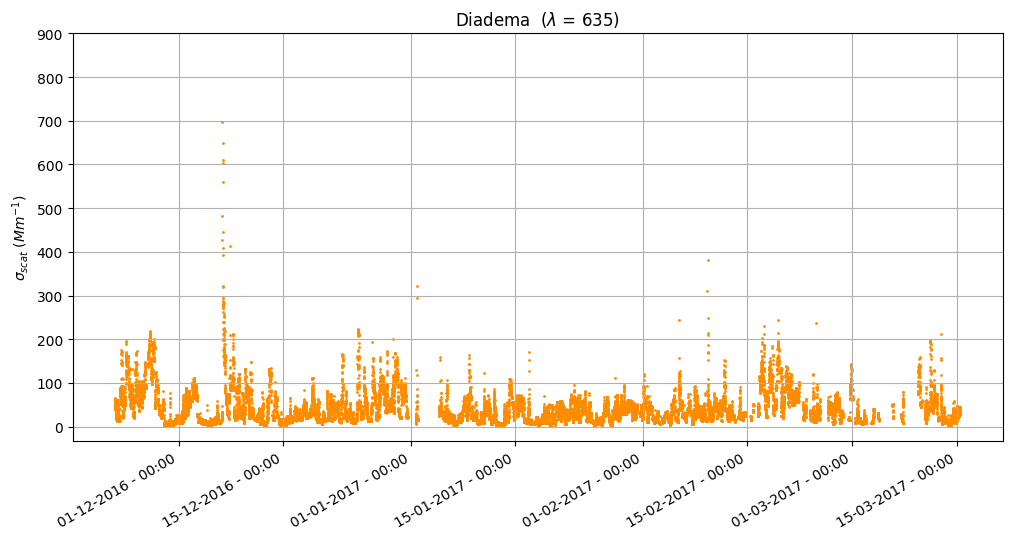

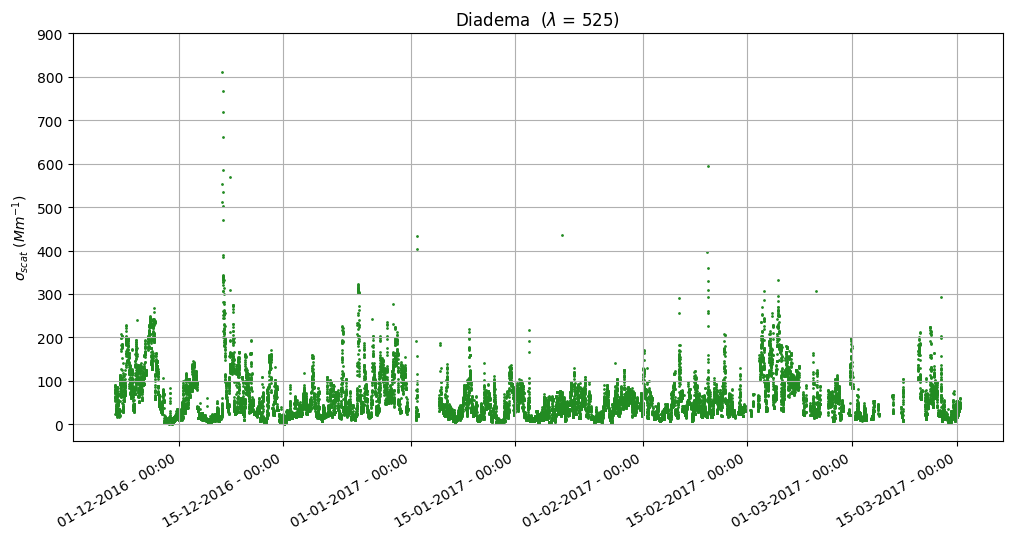

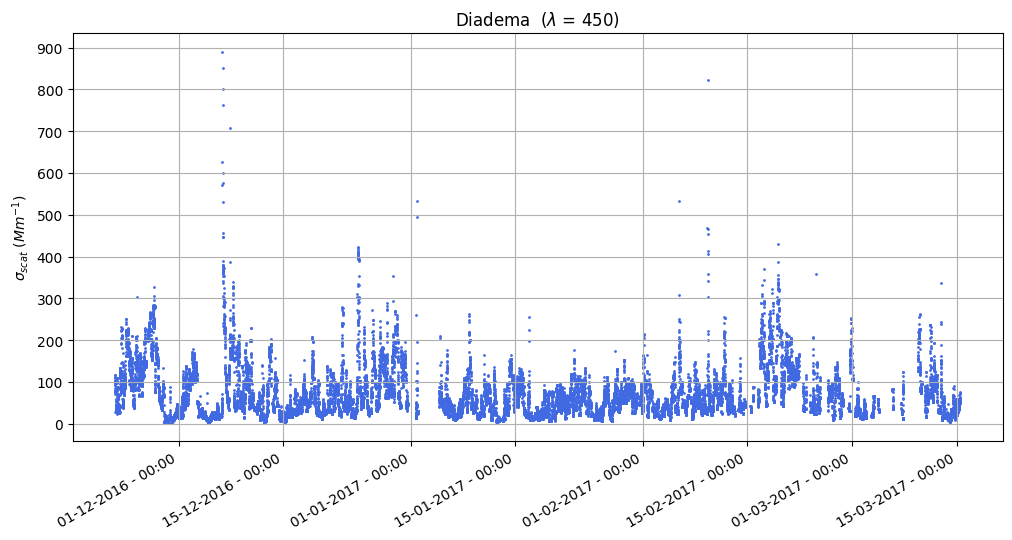

In [3]:
plots = [orange,green,blue]
cores = ['darkorange','forestgreen','royalblue']
labels=['635','525','450']

for i in range(len(plots)):
    plt.figure(figsize=(12, 6))
    plt.scatter(nefe.index, plots[i], color=cores[i],s=1)
    #plt.plot(nefe.index, green, color='forestgreen', label='Total scatt Green')
    #plt.plot(nefe.index, blue, color='royalblue', label='Total scatt Blue')
    plt.ylabel('$\sigma_{scat}~(Mm^{-1})$')
    plt.yticks(np.arange(0, 1000, 100))

    plt.title('Diadema  ($\lambda$ = %s)'%(labels[i]))

    # Formatando o eixo X para mostrar a nefe e hora
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))
    plt.gcf().autofmt_xdate()  # Rotaciona os rótulos do eixo X para melhor legibilidade

    #plt.legend()  # Mostra a legenda
    plt.grid()  # Adiciona a grade ao gráfico
    plt.show()

### SAE
- A incerteza (região sombreada) foi retirada da matriz de covariância do ajuste log linear.
- Ainda preciso investigar o porque de um dos pontos no centro ter uma incerteza tão grande.

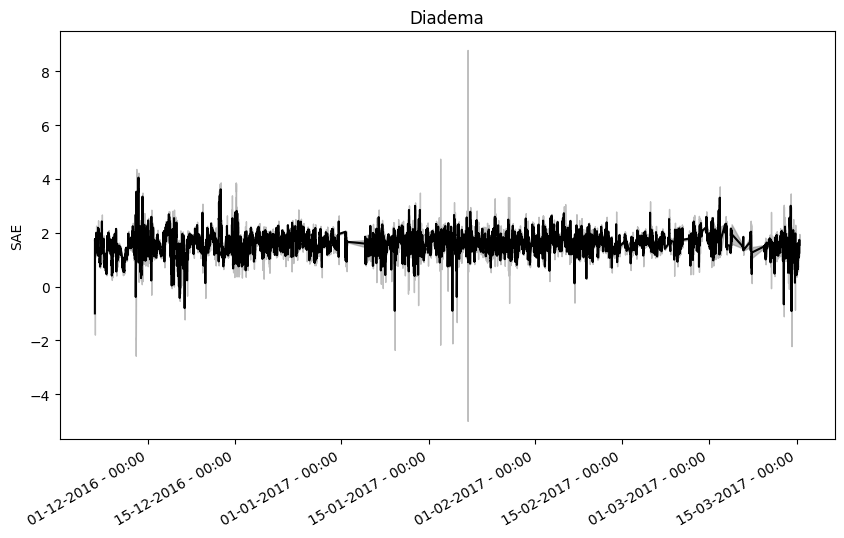

In [4]:
nefe[' scat637 Mean (Mm-1)'] = np.nan
nefe['SAE'] = np.nan
nefe['sigma_SAE'] = np.nan

lambdas = [635,525,450]
for i in range(len(nefe)):
    sigma = [orange[i],green[i],blue[i]]
    coeff, cov_matrix = np.polyfit(np.log(lambdas),np.log(sigma), 1,cov= True)
    nefe.at[nefe.index[i], 'SAE'] = -coeff[0]
    sigmaSAE = np.sqrt(cov_matrix[0, 0])
    scat637i = np.exp(coeff[0]*np.log(637) + coeff[1])
    nefe.at[nefe.index[i], ' scat637 Mean (Mm-1)'] = scat637i
    nefe.at[nefe.index[i], 'sigma_SAE'] = sigmaSAE


plt.figure(figsize=(10,6))
plt.plot(nefe.index, nefe['SAE'], color='black')

# Adiciona a sombra das incertezas usando fill_between
plt.fill_between(
    nefe.index,
    nefe['SAE'] - nefe['sigma_SAE'],  # Limite inferior da sombra
    nefe['SAE'] + nefe['sigma_SAE'],  # Limite superior da sombra
    color='gray',
    alpha=0.5,  # Transparência da sombra
    label='Incerteza'
)
plt.ylabel('SAE')
plt.title('Diadema')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))  # Exemplo: mostrar apenas horas e minutos
plt.gcf().autofmt_xdate() # Rotaciona os rótulos do eixo X para melhor legibilidade

#plt.legend()
#plt.grid()
plt.show()

## 16/09/2024

### Adicionando os novos dados

In [5]:
smps = pd.read_csv('data/Diadema-2016_SMPS_TSI_3082_Level3_5min_Henrique.csv', header=1)
smps = smps[smps['Number concentration (cm-3)']!= ' NaN']#remove linhas com valores nulos na coluna
smps = smps[smps['Total volume (um3.cm-3)']!= ' NaN']#remove linhas com valores nulos na coluna
smps = smps[smps[' Mean geometric diameter Dpg (nm)']!= ' NaN']#remove linhas com valores nulos na coluna


smps = smps.reset_index()

time = pd.to_datetime(smps['Time(UTC)'], format='%m/%d/%Y %H:%M') #transformando para o formato datetime que é útlil em python
smps = smps.drop('Time(UTC)', axis=1)
smps['Time(UTC)'] = time
# Definindo a coluna de nefe e hora como índice
smps.set_index('Time(UTC)', inplace=True)

smps['Number concentration (cm-3)'] = smps['Number concentration (cm-3)'].astype(float) #passando de string para float
smps['Total volume (um3.cm-3)'] = smps['Total volume (um3.cm-3)'].astype(float)#passando de string para float
smps[' Mean geometric diameter Dpg (nm)'] = smps[' Mean geometric diameter Dpg (nm)'].astype(float)#passando de string para float
smps.index = smps.index - timedelta(hours=3)
nc = smps['Number concentration (cm-3)']
totVolume = smps['Total volume (um3.cm-3)']
mgd = smps[' Mean geometric diameter Dpg (nm)']

In [6]:
#Coincidencia de períodos

indices_comuns = nefe.index.intersection(smps.index)

# Filtrando os data sets para manter apenas os índices comuns
nefe_filtrado = nefe.loc[indices_comuns]
smps_filtrado = smps.loc[indices_comuns]
#medias
nefe_filtrado = nefe_filtrado.resample('1440min').mean()
smps_filtrado = smps_filtrado.resample('1440min').mean()

orange_filtrado = nefe_filtrado[' scat635 Mean (Mm-1)']
green_filtrado = nefe_filtrado[' scat525 Mean (Mm-1)']
blue_filtrado = nefe_filtrado[' scat450 Mean (Mm-1)']
filtrado637 = nefe_filtrado[' scat637 Mean (Mm-1)']
sae_filtrado = nefe_filtrado['SAE']

nc_filtrado = smps_filtrado['Number concentration (cm-3)']
totVolume_filtrado = smps_filtrado['Total volume (um3.cm-3)']
mgd_filtrado = smps_filtrado[' Mean geometric diameter Dpg (nm)']

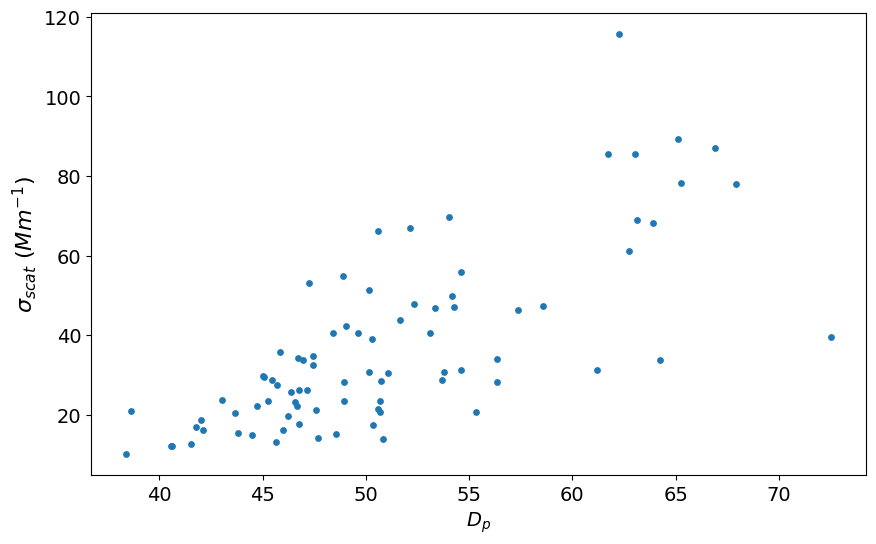

In [49]:
x = mgd_filtrado
y = filtrado637 
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=15)


plt.xlabel('$D_p$', fontsize=14)
plt.ylabel('$\sigma_{scat}~(Mm^{-1})$',fontsize=16)
#plt.title('Diadema')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))  # Exemplo: mostrar apenas horas e minutos
#plt.gcf().autofmt_xdate() # Rotaciona os rótulos do eixo X para melhor legibilidade
plt.xticks(fontsize=14)  # Para o eixo X
plt.yticks(fontsize=14)  # Para o eixo Y
#plt.legend()
#plt.grid()
plt.show()

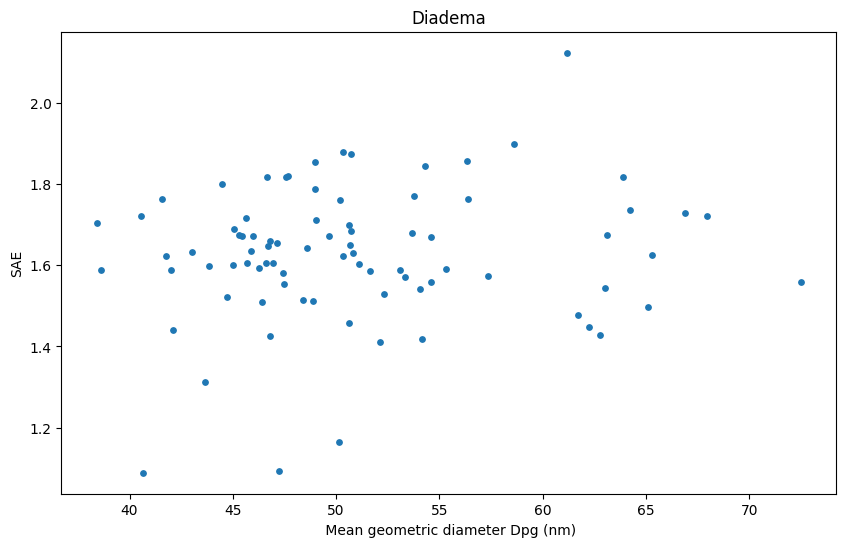

In [8]:
x = mgd_filtrado
y = sae_filtrado
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=15)


plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('Diadema')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))  # Exemplo: mostrar apenas horas e minutos
#plt.gcf().autofmt_xdate() # Rotaciona os rótulos do eixo X para melhor legibilidade

#plt.legend()
#plt.grid()
plt.show()

- Também plotei o coeficiente de espalhamento em função da concentração de partículas porque imaginei que uma maior concentração de partículas resultaria em mais radiação espalhada pela amostra de ar. Mas não sei se da pra ver muito bem essa correlação.

- Tem alguns dados que me parecem ser "outliers". O que fazer com isso? Caso fossemos ajustar uma reta, por exemplo.

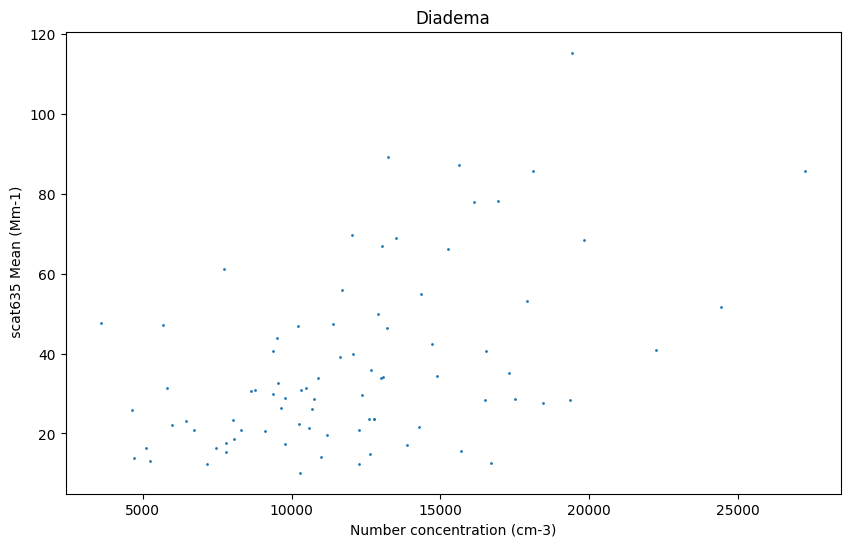

In [9]:
x = nc_filtrado
y = orange_filtrado
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=1)


plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('Diadema')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))  # Exemplo: mostrar apenas horas e minutos
#plt.gcf().autofmt_xdate() # Rotaciona os rótulos do eixo X para melhor legibilidade

#plt.legend()
#plt.grid()
plt.show()

Eu entendo que partículas maiores tendem a espalhar mais luz (Figura abaixo) mas não tenho certeza se é possível tirar a mesma conclusão pelo plot abaixo.

Aqui parece até uma distribuição mas também não compreendo o porque do SAE não seguir a lógica de crescer para particulas menores.

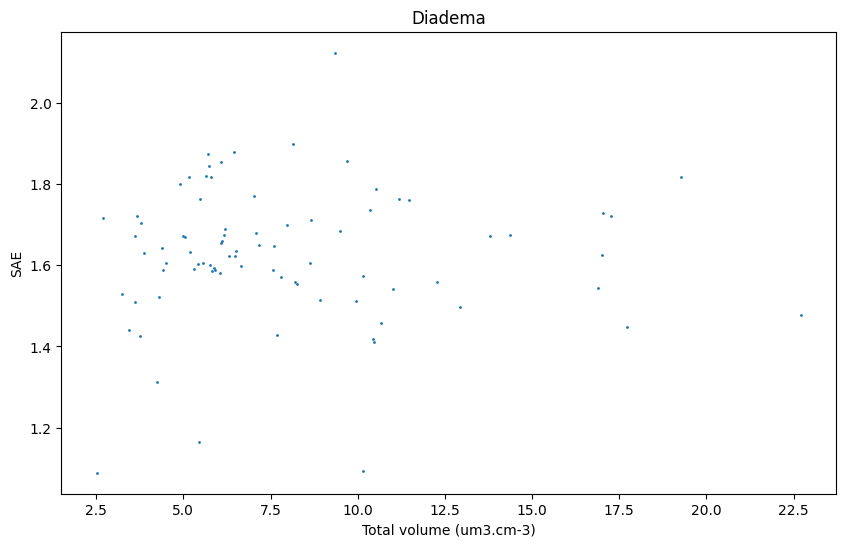

In [10]:
x = totVolume_filtrado
y = sae_filtrado
plt.figure(figsize=(10,6))
plt.scatter(x,y,s=1)


plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('Diadema')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))  # Exemplo: mostrar apenas horas e minutos
#plt.gcf().autofmt_xdate() # Rotaciona os rótulos do eixo X para melhor legibilidade

#plt.legend()
#plt.grid()
plt.show()

### Dúvidas

- Eu entendi a relação entre a dependência espectral e o SAE ser alto/baixo. Mas não entendi como relacionar isso ao tamanho das partículas. Na p. 69 da apostila de Meteorologia Física tem uma explicação baseada no fator de eficiência de espalhamento Q, (que por sua vez depende da seção de choque de espalhamento, do tamanho da partícula e do comprimento de onda), a explicação da apostila é baseada em algum cálculo ou em dados experimentais? 

## 23/09/2024

### Dados Meteorológicos

In [11]:
meteo = pd.read_csv('data/Diadema-2016_Meteo_1hour.csv', encoding='latin-1',header=1,sep=';') #o que é esse latin-1?  
abrev = ['Nov','Dec','Jan','Feb','Mar']
numero_mes = ['11','12','1','2','3']
time = meteo['Local Time(UTC-3)']
for j in range(len(abrev)):

    for i in range(len(meteo)):
        if time[i][3:6] == abrev[j]:
            time = time.str.replace(abrev[j],numero_mes[j])

meteo['Local Time(UTC-3)'] = time
meteo['Local Time(UTC-3)'] = meteo['Local Time(UTC-3)'].str.strip()


time = pd.to_datetime(meteo['Local Time(UTC-3)'], format='%d-%m-%Y %H:%M:%S') #transformando para o formato datetime que é útlil em python

meteo = meteo.drop('Local Time(UTC-3)', axis=1)
meteo['Local Time(UTC-3)'] = time
meteo.set_index('Local Time(UTC-3)', inplace=True)

for column in meteo.columns:
   meteo['%s'%(column)] = meteo['%s'%(column)].astype(float)

#meteo.index = meteo.index - timedelta(hours=3)

### Ciclo diurno médio

In [12]:

nefe_media_1h = nefe.resample('60min').mean()

nefe_media_1h['hour'] = nefe_media_1h.index.hour
# Agrupando por hora e calculando a média
nefe_cdm = nefe_media_1h.groupby('hour').mean()

smps_media_1h = smps.resample('60min').mean()
smps_media_1h['hour'] = smps_media_1h.index.hour
# Agrupando por hora e calculando a média
smps_cdm = smps_media_1h.groupby('hour').mean()

meteo['hour'] = meteo.index.hour
# Agrupando por hora e calculando a média
meteo_cdm = meteo.groupby('hour').mean()

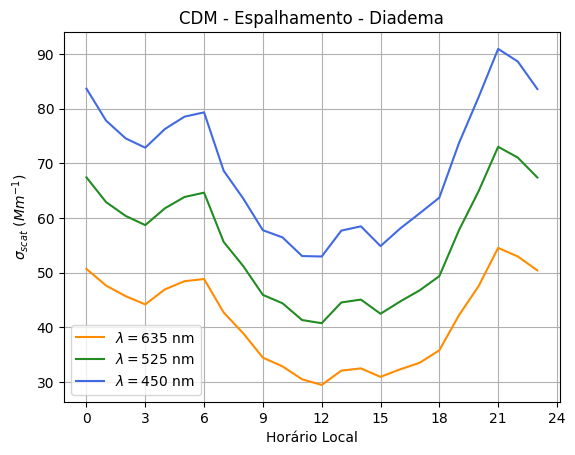

In [13]:
plots = [nefe_cdm[' scat635 Mean (Mm-1)'],nefe_cdm[' scat525 Mean (Mm-1)'],nefe_cdm[' scat450 Mean (Mm-1)']]
cores = ['darkorange','forestgreen','royalblue']
labels=['635','525','450']

for i in range(len(plots)):
    plt.plot(nefe_cdm.index, plots[i], color=cores[i],label='$\lambda = $%s nm'%(labels[i]))


plt.ylabel('$\sigma_{scat}~(Mm^{-1})$')
plt.xticks(np.arange(0, 24.001,3))
plt.xlabel('Horário Local')
plt.title('CDM - Espalhamento - Diadema')
plt.legend() 
plt.grid()
plt.show()    

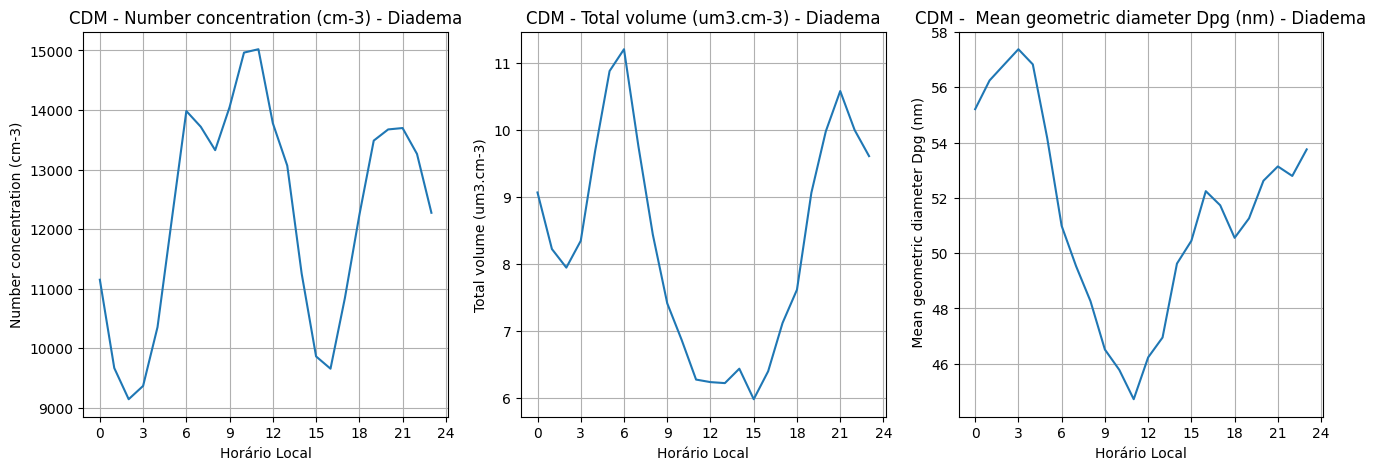

In [14]:
fig, coluna = plt.subplots(1, 3, figsize=(16, 5))


labels=['Number concentration (cm-3)','Total volume (um3.cm-3)',' Mean geometric diameter Dpg (nm)']

for i in range(len(labels)):
    coluna[i].plot(smps_cdm.index,smps_cdm[labels[i]])
    coluna[i].set_ylabel(labels[i])
    coluna[i].set_xticks(np.arange(0, 24.001,3))
    coluna[i].set_xlabel('Horário Local')
    coluna[i].set_title('CDM - %s - Diadema'%(labels[i]))
    coluna[i].grid()


plt.show()  

- Lembro de você ter me comentado que o horário de chuva de SP no verão é por volta das 14h e me parece estar coerente e isso também parece se relacionar com o menor valor de espalhamento 

- A concentração em número não parece cair apesar da chuva. A chuva não "limpa" a atmosfera?


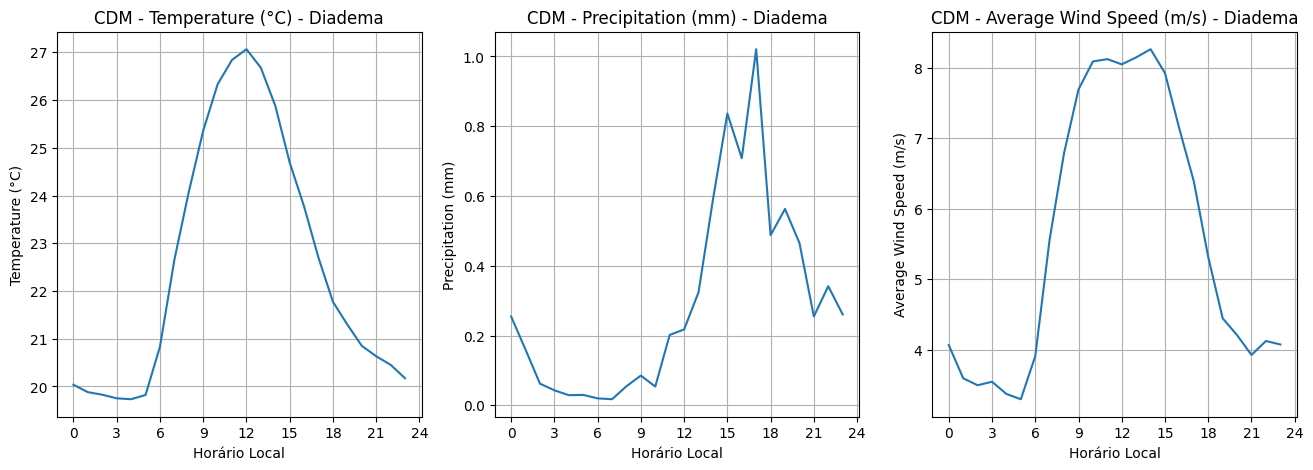

In [15]:
fig, coluna = plt.subplots(1, 3, figsize=(16, 5))

labels=['Temperature (°C)','Precipitation (mm)','Average Wind Speed (m/s)']

for i in range(len(labels)):
    coluna[i].plot(meteo_cdm.index,meteo_cdm[labels[i]])
    coluna[i].set_ylabel(labels[i])
    coluna[i].set_xticks(np.arange(0, 24.001,3))
    coluna[i].set_xlabel('Horário Local')
    coluna[i].set_title('CDM - %s - Diadema'%(labels[i]))
    coluna[i].grid()

plt.show()  

camada limite


## 30/09/2024

## Dados de Absorção

In [16]:
maap = pd.read_csv("data/Diadema-2016_MAAP_5012_Level2_5min.csv",sep=';', header=1)
maap = maap.dropna(subset=[' Abs637 Mean (Mm-1)'])#remove linhas com valores nulos na coluna
abrev = ['Nov','Dec','Jan','Feb','Mar']
numero_mes = ['11','12','1','2','3']
time = maap['Time(UTC)']
for j in range(len(abrev)):

    for i in range(len(maap)):
        if time[i][3:6] == abrev[j]:
            time = time.str.replace(abrev[j],numero_mes[j])

maap['Time(UTC)'] = time
maap['Time(UTC)'] = maap['Time(UTC)'].str.strip()


time = pd.to_datetime(maap['Time(UTC)'], format='%d-%m-%Y %H:%M') #transformando para o formato datetime que é útlil em python

maap = maap.drop('Time(UTC)', axis=1)
maap['Time(UTC)'] = time
maap.set_index('Time(UTC)', inplace=True)


for column in maap.columns:
   maap['%s'%(column)] = maap['%s'%(column)].astype(float)

maap = maap.dropna(subset=[' Abs637 Mean (Mm-1)'])#remove linhas com valores nulos na coluna


maap.index = maap.index - timedelta(hours=3)

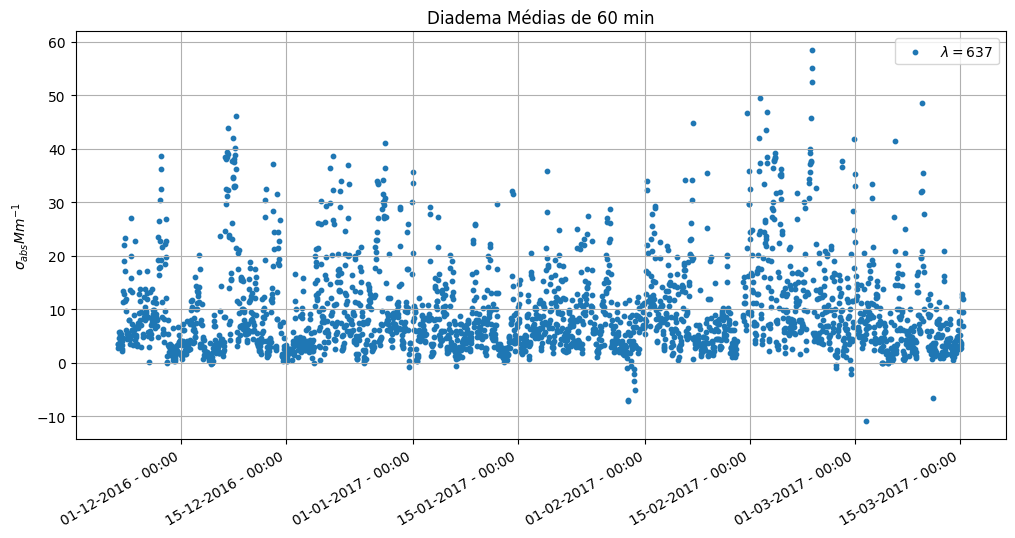

In [17]:

maap_1h = maap.resample('60min').mean()
plt.figure(figsize=(12, 6))
plt.scatter(maap_1h.index,maap_1h[' Abs637 Mean (Mm-1)'] ,s=10,label='$\lambda = 637$')

plt.ylabel('$\sigma_{abs} Mm^{-1}$')
plt.title('Diadema Médias de 60 min')

# Formatando o eixo X para mostrar a nefe e hora
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))
plt.gcf().autofmt_xdate()  # Rotaciona os rótulos do eixo X para melhor legibilidade

#plt.legend()  # Mostra a legenda
plt.grid()  # Adiciona a grade ao gráfico
plt.legend()
plt.show()

## SSA (Single Scaterring Albedo)

In [18]:
indices_comuns_albedo = nefe.index.intersection(maap.index)

# Filtrando os data sets para manter apenas os índices comuns
nefe_albedo_filtrado = nefe.loc[indices_comuns_albedo]
maap_filtrado = maap.loc[indices_comuns_albedo]




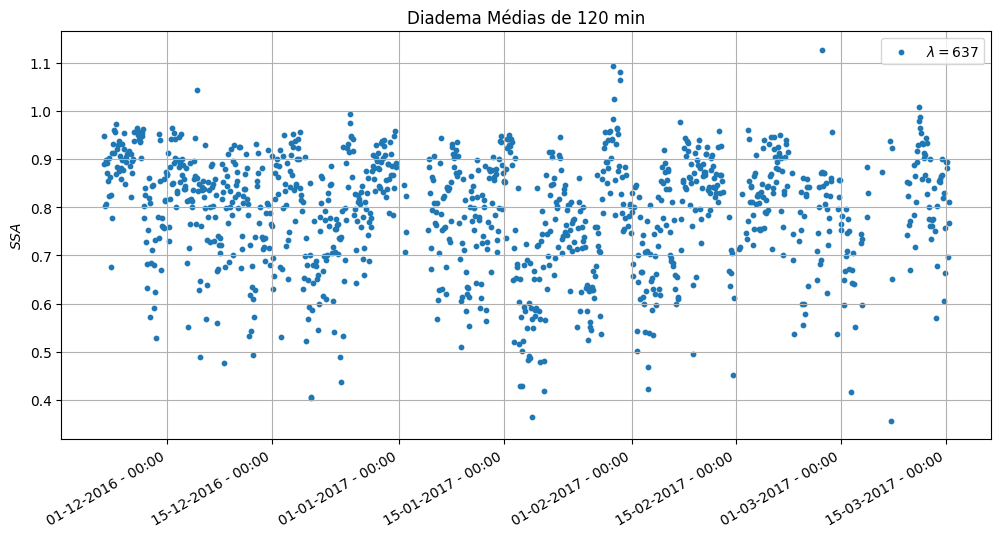

In [19]:

nefe_albedo_filtrado = nefe_albedo_filtrado.resample('60min').mean()
maap_filtrado = maap_filtrado.resample('120min').mean()

scat637_filtrado = nefe_albedo_filtrado[' scat637 Mean (Mm-1)']
abs637_filtrado =  maap_filtrado[' Abs637 Mean (Mm-1)']

albedo = scat637_filtrado/(scat637_filtrado + abs637_filtrado)
plt.figure(figsize=(12, 6))
plt.scatter(nefe_albedo_filtrado.index,albedo ,s=10,label='$\lambda = 637$')

plt.ylabel('$SSA$')
plt.title('Diadema Médias de 120 min')

# Formatando o eixo X para mostrar a nefe e hora
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y - %H:%M'))
plt.gcf().autofmt_xdate()  # Rotaciona os rótulos do eixo X para melhor legibilidade

#plt.legend()  # Mostra a legenda
plt.grid()  # Adiciona a grade ao gráfico
plt.legend()
plt.show()

Ciclo Diurno Medio

In [20]:
nefe_albedo_media_1h = nefe.resample('60min').mean()

nefe_albedo_media_1h['hour'] = nefe_albedo_media_1h.index.hour
# Agrupando por hora e calculando a média
nefe_albedo_cdm = nefe_albedo_media_1h.groupby('hour').mean()

maap_media_1h = maap.resample('60min').mean()

maap_media_1h['hour'] = maap_media_1h.index.hour
# Agrupando por hora e calculando a média
maap_cdm = maap_media_1h.groupby('hour').mean()

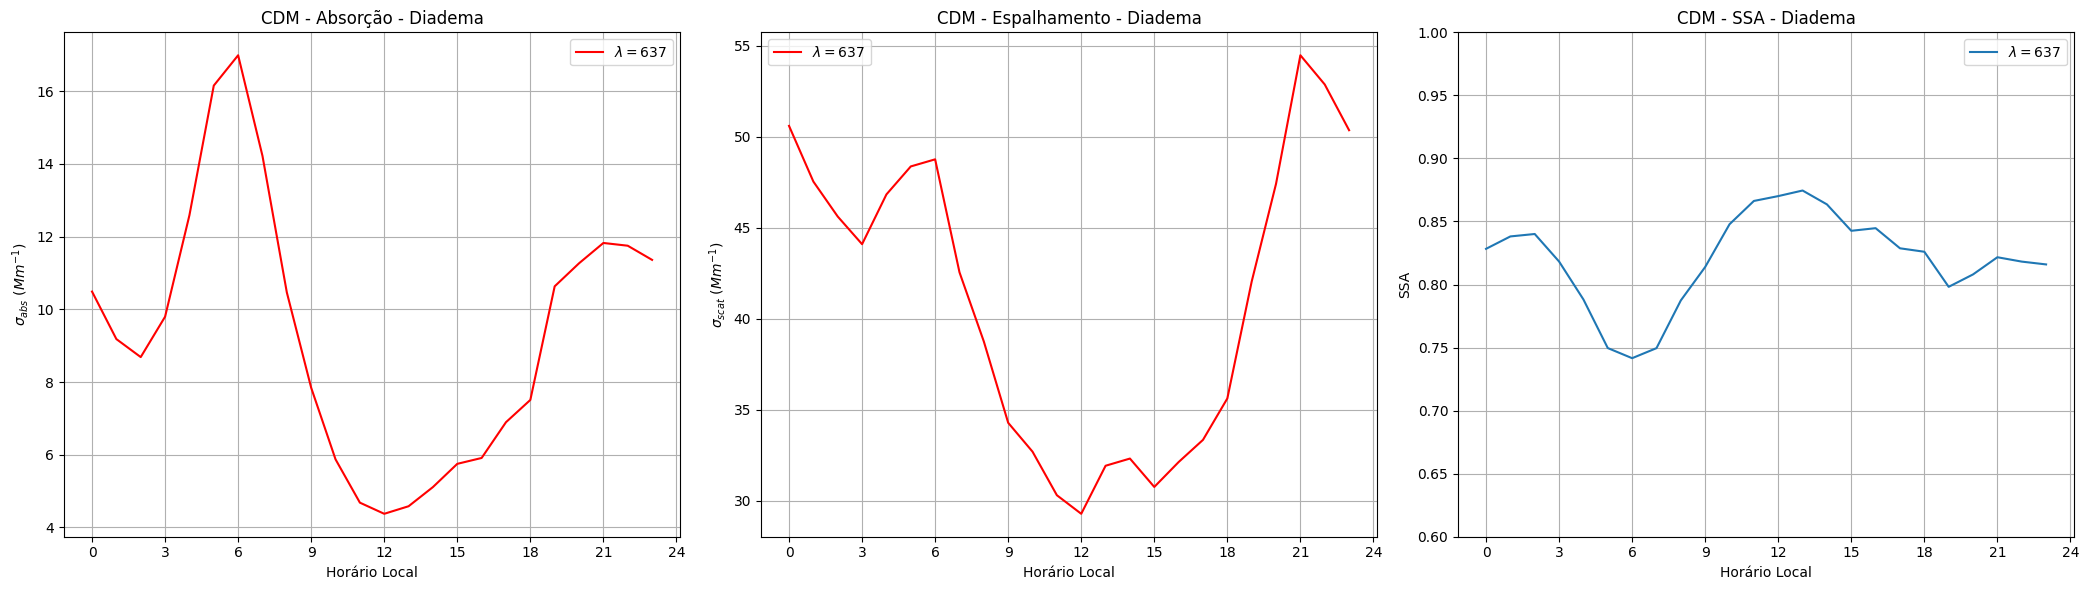

In [21]:

scat637_cdm = nefe_albedo_cdm[[' scat637 Mean (Mm-1)']]
scat637_cdm = scat637_cdm.squeeze()
abs637_cdm = maap_cdm[' Abs637 Mean (Mm-1)']
albedo_cdm = scat637_cdm/(scat637_cdm + abs637_cdm)

dados = [
    (maap_cdm.index, maap_cdm[' Abs637 Mean (Mm-1)'], '$\sigma_{abs}~(Mm^{-1})$', 'CDM - Absorção - Diadema', '$\sigma_{abs}~(Mm^{-1})$', None),
    (nefe_albedo_cdm.index, scat637_cdm, '$\sigma_{scat}~(Mm^{-1})$', 'CDM - Espalhamento - Diadema', '$\sigma_{scat}~(Mm^{-1})$', None),
    (maap_cdm.index, albedo_cdm, 'SSA', 'CDM - SSA - Diadema', 'SSA', (0.6, 1))
]

# Criar subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Loop para plotar os gráficos
for ax, (x, y, ylabel, title, label, ylim) in zip(axes, dados):
    ax.plot(x, y, label='$\lambda = 637$', color='red' if 'Absorção' in title or 'Espalhamento' in title else None)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Horário Local')
    ax.set_xticks(np.arange(0, 24.001, 3))
    #ax.set_ylim(0,80)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(title)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()



In [22]:
print('Valor maximo de absorção:', max(maap_cdm[' Abs637 Mean (Mm-1)']))
print('Valor minimo de absorção:', min(maap_cdm[' Abs637 Mean (Mm-1)']))

print()

print('Valor maximo de espalhamento:', max(scat637_cdm))
print('Valor minimo de espalhamento:', min(scat637_cdm))

print()

print('Valor maximo de albedo:', max(albedo_cdm))
print('Valor minimo de albedo:', min(albedo_cdm))


Valor maximo de absorção: 16.992185606060605
Valor minimo de absorção: 4.372893008314437

Valor maximo de espalhamento: 54.4806936002756
Valor minimo de espalhamento: 29.296668155720003

Valor maximo de albedo: 0.8745559093015486
Valor minimo de albedo: 0.7415898791247515


A curva de BC tem o exato mesmo formato da curva de absorção?
Tem sim, a única diferença entre as duas eh a multiplicacao de uma constante relacionada com a seção de choque de absorção do BC

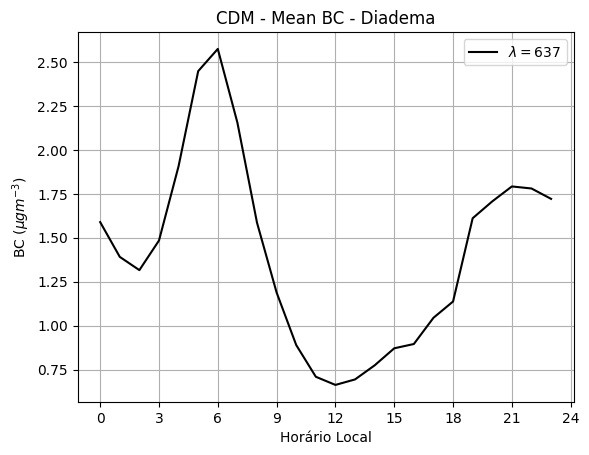

In [23]:
plt.plot(maap_cdm.index, maap_cdm[' BC637 Mean (ug.m-3)'],label='$\lambda = 637$',color='k')
plt.ylabel('BC $(\mu g m^{-3})$')
plt.xticks(np.arange(0, 24.001,3))
plt.xlabel('Horário Local')
plt.title('CDM - Mean BC - Diadema')
plt.legend() 
plt.grid()
plt.show()

# 14/10/2024

### Analise de Período de Chuva/Estiagem

In [24]:
from datetime import datetime

start_chuvoso = "2017-01-15 00:00:00"
start_chuvoso = datetime.strptime(start_chuvoso, "%Y-%m-%d %H:%M:%S")

end_chuvoso = "2017-01-22 00:00:00"
end_chuvoso = datetime.strptime(end_chuvoso, "%Y-%m-%d %H:%M:%S")


start_estiagem = "2017-02-08 00:00:00"
start_estiagem = datetime.strptime(start_estiagem, "%Y-%m-%d %H:%M:%S")

end_estiagem = "2017-02-20 00:00:00"
end_estiagem = datetime.strptime(end_estiagem, "%Y-%m-%d %H:%M:%S")


#### Chuvoso

In [25]:
nefe_chuvoso = nefe.loc[start_chuvoso:end_chuvoso]
nefe_albedo_media_1h_chuvoso = nefe_chuvoso.resample('60min').mean()

nefe_albedo_media_1h_chuvoso['hour'] = nefe_albedo_media_1h_chuvoso.index.hour
# Agrupando por hora e calculando a média
nefe_albedo_cdm_chuvoso = nefe_albedo_media_1h_chuvoso.groupby('hour').mean()

maap_chuvoso = maap.loc[start_chuvoso:end_chuvoso]
maap_media_1h_chuvoso = maap_chuvoso.resample('60min').mean()

maap_media_1h_chuvoso['hour'] = maap_media_1h_chuvoso.index.hour
# Agrupando por hora e calculando a média
maap_cdm_chuvoso = maap_media_1h_chuvoso.groupby('hour').mean()


scat637_cdm_chuvoso = nefe_albedo_cdm_chuvoso[[' scat637 Mean (Mm-1)']]
scat637_cdm_chuvoso = scat637_cdm_chuvoso.squeeze()

abs637_cdm_chuvoso = maap_cdm_chuvoso[' Abs637 Mean (Mm-1)']

albedo_cdm_chuvoso = scat637_cdm_chuvoso/(scat637_cdm_chuvoso + abs637_cdm_chuvoso)



### Estiagem

In [26]:
nefe_estiagem = nefe.loc[start_estiagem:end_estiagem]
nefe_albedo_media_1h_estiagem = nefe_estiagem.resample('60min').mean()

nefe_albedo_media_1h_estiagem['hour'] = nefe_albedo_media_1h_estiagem.index.hour
# Agrupando por hora e calculando a média
nefe_albedo_cdm_estiagem = nefe_albedo_media_1h_estiagem.groupby('hour').mean()

maap_estiagem = maap.loc[start_estiagem:end_estiagem]
maap_media_1h_estiagem = maap_estiagem.resample('60min').mean()

maap_media_1h_estiagem['hour'] = maap_media_1h_estiagem.index.hour
# Agrupando por hora e calculando a média
maap_cdm_estiagem = maap_media_1h_estiagem.groupby('hour').mean()


scat637_cdm_estiagem = nefe_albedo_cdm_estiagem[[' scat637 Mean (Mm-1)']]
scat637_cdm_estiagem = scat637_cdm_estiagem.squeeze()

abs637_cdm_estiagem = maap_cdm_estiagem[' Abs637 Mean (Mm-1)']

albedo_cdm_estiagem = scat637_cdm_estiagem/(scat637_cdm_estiagem + abs637_cdm_estiagem)



### Juntando Estiagem e Chuvoso

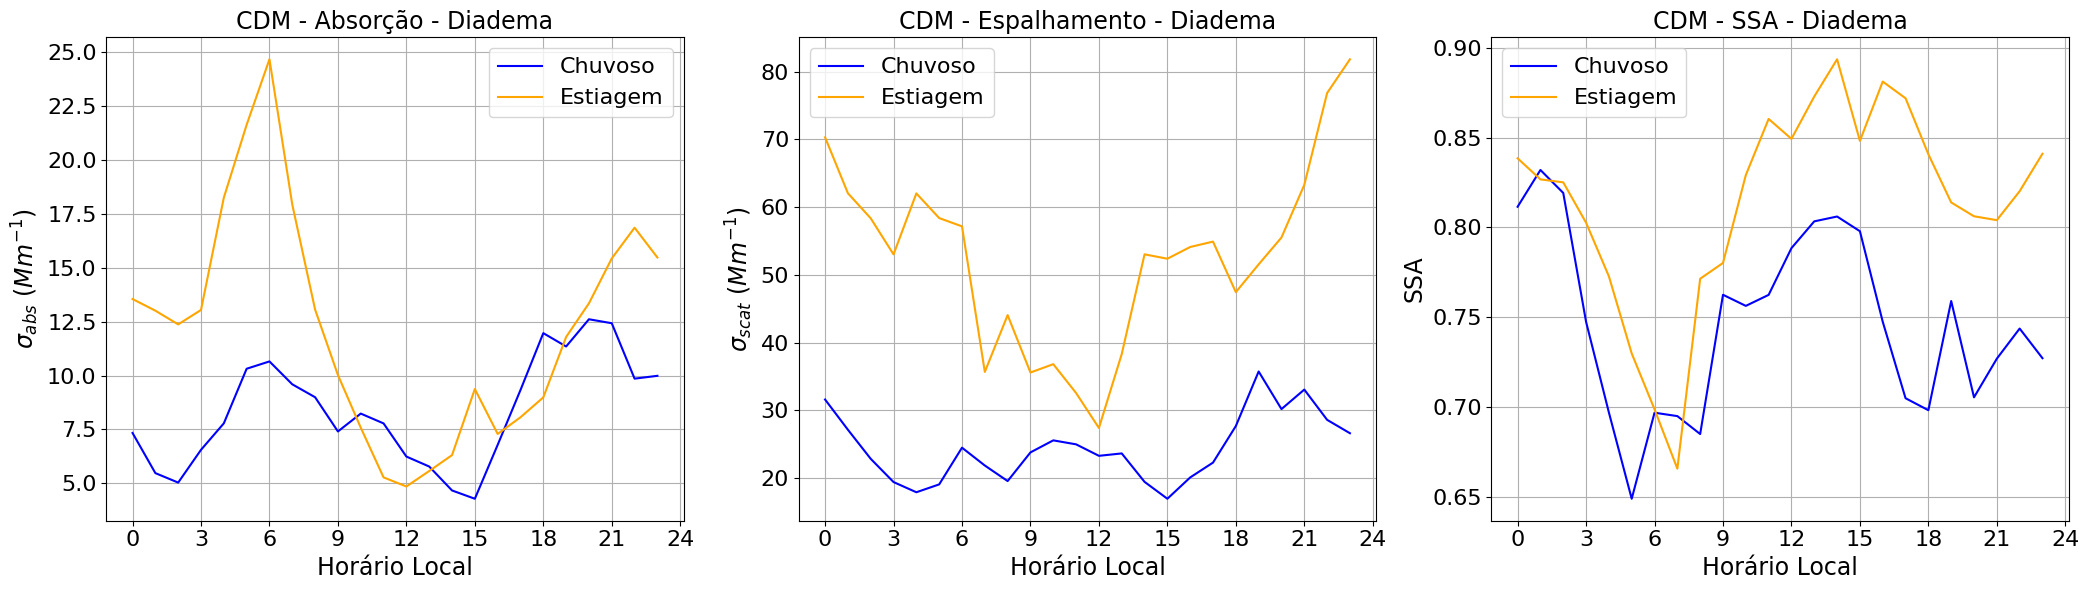

In [27]:
# Criar subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Dados chuvoso e estiagem organizados para o loop
dados = [
    # Absorção
    (maap_cdm_chuvoso.index, maap_cdm_chuvoso[' Abs637 Mean (Mm-1)'], maap_cdm_estiagem[' Abs637 Mean (Mm-1)'], 
     '$\sigma_{abs}~(Mm^{-1})$', 'CDM - Absorção - Diadema'),
    
    # Espalhamento
    (nefe_albedo_cdm_chuvoso.index, scat637_cdm_chuvoso, scat637_cdm_estiagem, 
     '$\sigma_{scat}~(Mm^{-1})$', 'CDM - Espalhamento - Diadema'),
    
    # Albedo (SSA)
    (maap_cdm_chuvoso.index, albedo_cdm_chuvoso, albedo_cdm_estiagem, 
     'SSA', 'CDM - SSA - Diadema')
]

# Loop para plotar os gráficos com períodos diferenciados por cor
for ax, (x_chuvoso, y_chuvoso, y_estiagem, ylabel, title) in zip(axes, dados):
    ax.plot(x_chuvoso, y_chuvoso, label='Chuvoso', color='blue')
    ax.plot(x_chuvoso, y_estiagem, label='Estiagem', color='orange')
    
    ax.set_ylabel(ylabel, fontsize=17)
    ax.set_xlabel('Horário Local', fontsize=17)
    ax.set_xticks(np.arange(0, 24.001, 3))
    ax.set_title(title, fontsize=17)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=16)
    ax.grid()

plt.tight_layout()
plt.show()


- Teve muitos valores do albedo que passaram de 1.0

## Plotando com a diferenciação fim de semana/ dia de semana

In [28]:
# Resample dos dados para média por hora
nefe_albedo_media_1h = nefe.resample('60min').mean()
nefe_albedo_media_1h['hour'] = nefe_albedo_media_1h.index.hour
nefe_albedo_media_1h['weekday'] = nefe_albedo_media_1h.index.weekday  # Adiciona coluna para dia da semana

# Separando dias de semana (segunda a sexta, weekday 0 a 4) e fim de semana (sábado e domingo, weekday 5 e 6)
nefe_semana = nefe_albedo_media_1h[nefe_albedo_media_1h['weekday'] < 5]
nefe_fim_semana = nefe_albedo_media_1h[nefe_albedo_media_1h['weekday'] >= 5]

# Agrupando por hora e calculando a média para dias de semana
nefe_semana_cdm = nefe_semana.groupby('hour').mean()

# Agrupando por hora e calculando a média para fim de semana
nefe_fim_semana_cdm = nefe_fim_semana.groupby('hour').mean()

# Repetindo o processo para maap
maap_media_1h = maap.resample('60min').mean()
maap_media_1h['hour'] = maap_media_1h.index.hour
maap_media_1h['weekday'] = maap_media_1h.index.weekday

# Separando dias de semana e fim de semana
maap_semana = maap_media_1h[maap_media_1h['weekday'] < 5]
maap_fim_semana = maap_media_1h[maap_media_1h['weekday'] >= 5]

# Agrupando por hora e calculando a média para dias de semana
maap_semana_cdm = maap_semana.groupby('hour').mean()

# Agrupando por hora e calculando a média para fim de semana
maap_fim_semana_cdm = maap_fim_semana.groupby('hour').mean()


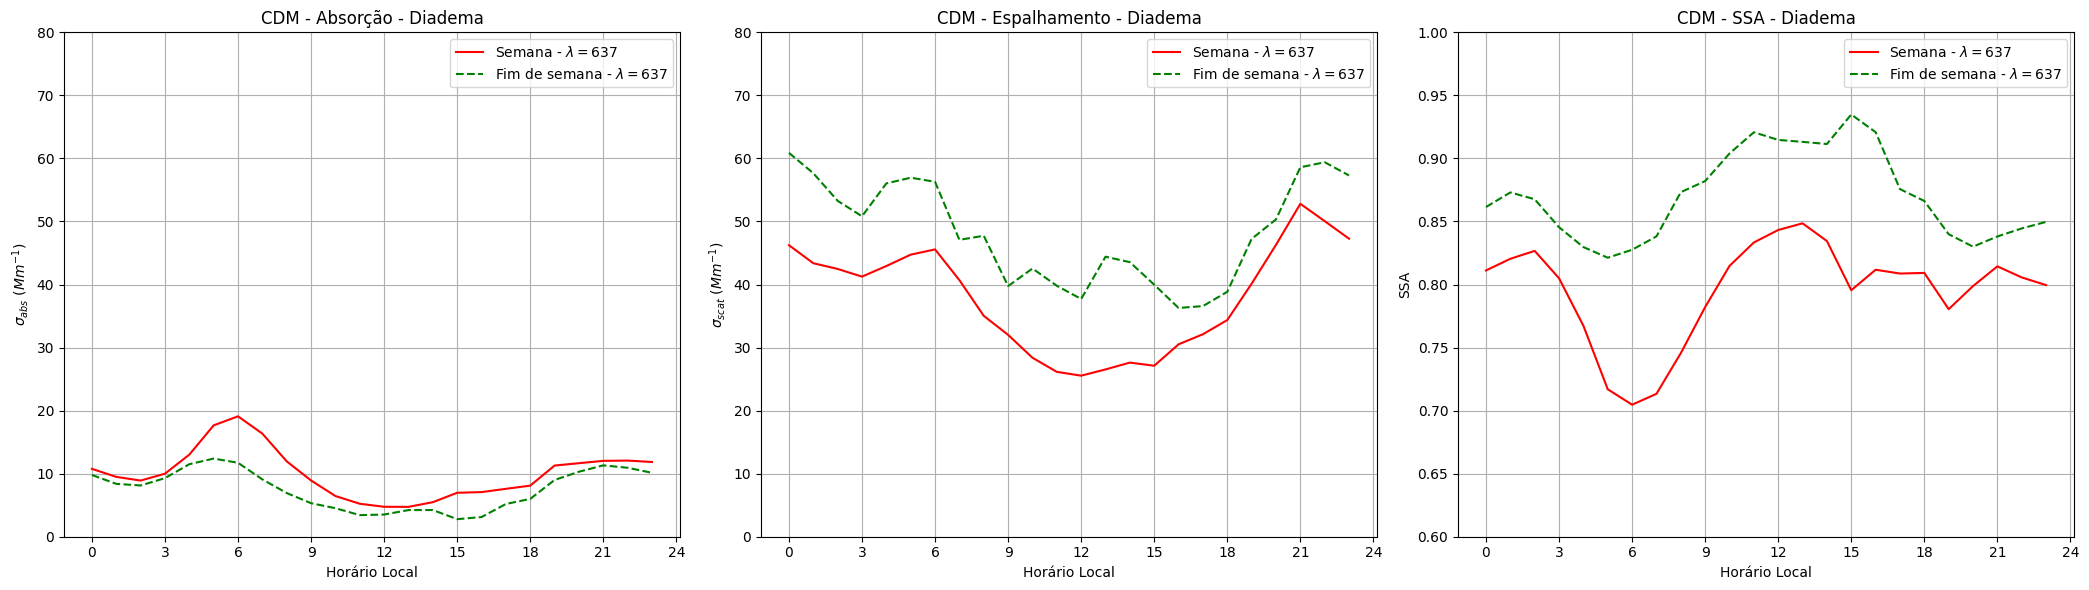

In [29]:
# Cálculo do ciclo diurno médio para dias de semana e fim de semana
scat637_semana_cdm = nefe_semana_cdm[[' scat637 Mean (Mm-1)']].squeeze()
scat637_fim_semana_cdm = nefe_fim_semana_cdm[[' scat637 Mean (Mm-1)']].squeeze()

abs637_semana_cdm = maap_semana_cdm[' Abs637 Mean (Mm-1)']
abs637_fim_semana_cdm = maap_fim_semana_cdm[' Abs637 Mean (Mm-1)']

albedo_semana_cdm = scat637_semana_cdm / (scat637_semana_cdm + abs637_semana_cdm)
albedo_fim_semana_cdm = scat637_fim_semana_cdm / (scat637_fim_semana_cdm + abs637_fim_semana_cdm)

# Dados para plotagem
dados = [
    # Absorção
    (maap_semana_cdm.index, abs637_semana_cdm, maap_fim_semana_cdm.index, abs637_fim_semana_cdm, '$\sigma_{abs}~(Mm^{-1})$', 'CDM - Absorção - Diadema', '$\sigma_{abs}~(Mm^{-1})$', None),
    # Espalhamento
    (nefe_semana_cdm.index, scat637_semana_cdm, nefe_fim_semana_cdm.index, scat637_fim_semana_cdm, '$\sigma_{scat}~(Mm^{-1})$', 'CDM - Espalhamento - Diadema', '$\sigma_{scat}~(Mm^{-1})$', None),
    # Albedo
    (maap_semana_cdm.index, albedo_semana_cdm, maap_fim_semana_cdm.index, albedo_fim_semana_cdm, 'SSA', 'CDM - SSA - Diadema', 'SSA', (0.6, 1))
]

# Criar subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Loop para plotar os gráficos
for ax, (x_semana, y_semana, x_fim_semana, y_fim_semana, ylabel, title, label, ylim) in zip(axes, dados):
    ax.plot(x_semana, y_semana, label='Semana - $\lambda = 637$', color='red')
    ax.plot(x_fim_semana, y_fim_semana, label='Fim de semana - $\lambda = 637$', color='green', linestyle='--')
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Horário Local')
    ax.set_xticks(np.arange(0, 24.001, 3))
    ax.set_ylim(0,80)
    if ylim:
        ax.set_ylim(ylim)
        
    ax.set_title(title)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


## Relatório Diadema

### Boxplot

In [30]:
tempo = 60
maap_estiagem_dia =  maap_estiagem.resample(f'{tempo}min').mean()
maap_chuvoso_dia =  maap_chuvoso.resample(f'{tempo}min').mean()

nefe_estiagem_dia =  nefe_estiagem.resample(f'{tempo}min').mean()
nefe_chuvoso_dia =  nefe_chuvoso.resample(f'{tempo}min').mean()



scat637_chuvoso_dia = nefe_chuvoso_dia[' scat637 Mean (Mm-1)'].values.flatten()
scat637_estiagem_dia = nefe_estiagem_dia[' scat637 Mean (Mm-1)'].values.flatten()


abs637_chuvoso_dia = maap_chuvoso_dia[' Abs637 Mean (Mm-1)'].values.flatten()
abs637_estiagem_dia = maap_estiagem_dia[' Abs637 Mean (Mm-1)'].values.flatten()



albedo_chuvoso_dia = scat637_chuvoso_dia/(scat637_chuvoso_dia + abs637_chuvoso_dia).flatten()

#albedo_chuvoso = albedo_chuvoso[(albedo_chuvoso > 0.0) & (albedo_chuvoso < 1.0)]

albedo_estiagem_dia = scat637_estiagem_dia/(scat637_estiagem_dia + abs637_estiagem_dia).flatten()
#albedo_estiagem = albedo_estiagem[(albedo_estiagem > 0.0) & (albedo_estiagem < 1.0)]

SAE_chuvoso_dia = nefe_chuvoso_dia['SAE'].values.flatten()
SAE_estiagem_dia = nefe_estiagem_dia['SAE'].values.flatten()


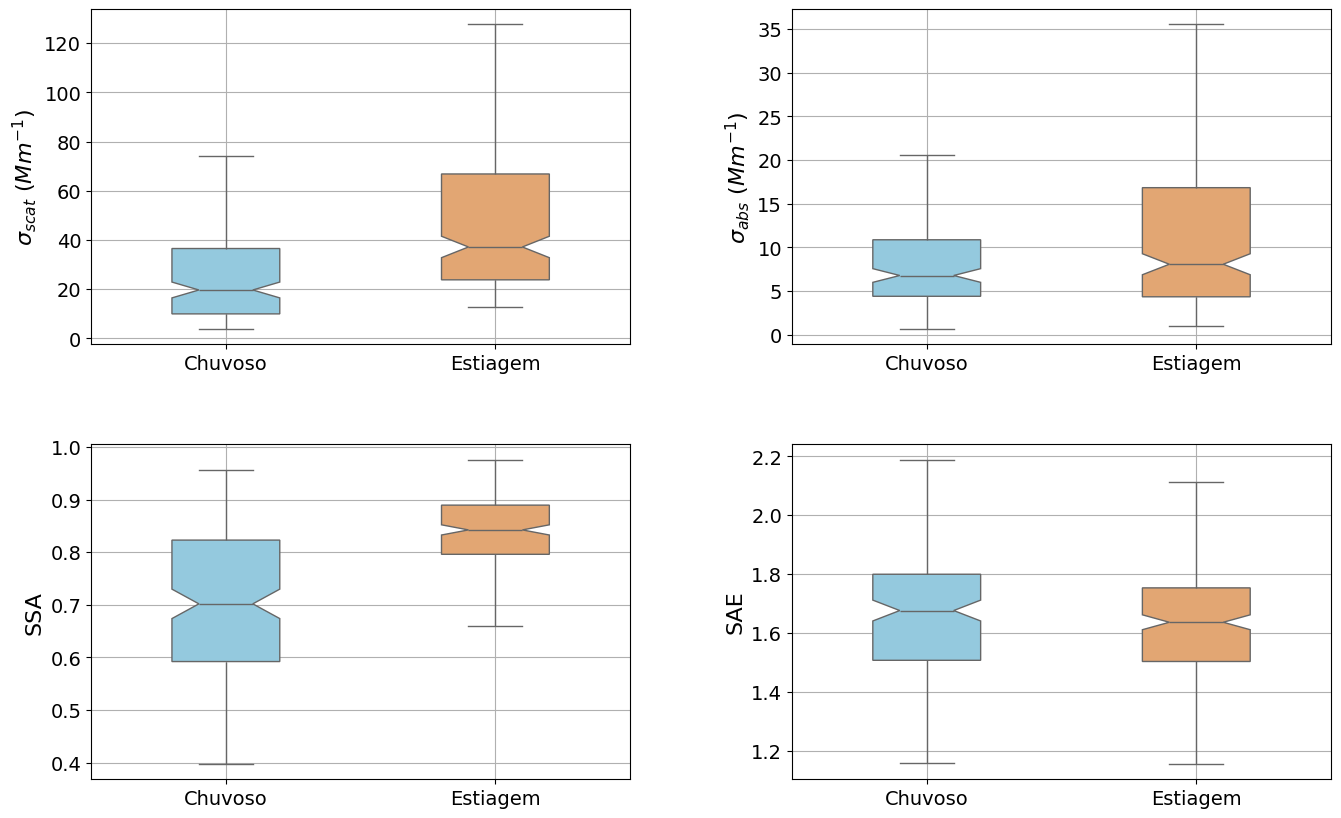

In [31]:
# Preparando os dados para o Seaborn em formato de DataFrame
df_comparativo = pd.DataFrame({
    'Valores': np.concatenate([
        scat637_chuvoso_dia, scat637_estiagem_dia, 
        abs637_chuvoso_dia, abs637_estiagem_dia, 
        albedo_chuvoso_dia, albedo_estiagem_dia, 
        SAE_chuvoso_dia, SAE_estiagem_dia
    ]),
    'Métrica': (['$\sigma_{scat}~(Mm^{-1})$'] * len(scat637_chuvoso_dia) +
                ['$\sigma_{scat}~(Mm^{-1})$'] * len(scat637_estiagem_dia) +
                ['$\sigma_{abs}~(Mm^{-1})$'] * len(abs637_chuvoso_dia) +
                ['$\sigma_{abs}~(Mm^{-1})$'] * len(abs637_estiagem_dia) +
                ['SSA'] * len(albedo_chuvoso_dia) +
                ['SSA'] * len(albedo_estiagem_dia) +
                ['SAE'] * len(SAE_chuvoso_dia) +
                ['SAE'] * len(SAE_estiagem_dia)),
    'Período': (['Chuvoso'] * len(scat637_chuvoso_dia) + 
                ['Estiagem'] * len(scat637_estiagem_dia) +
                ['Chuvoso'] * len(abs637_chuvoso_dia) +
                ['Estiagem'] * len(abs637_estiagem_dia) +
                ['Chuvoso'] * len(albedo_chuvoso_dia) +
                ['Estiagem'] * len(albedo_estiagem_dia) +
                ['Chuvoso'] * len(SAE_chuvoso_dia) +
                ['Estiagem'] * len(SAE_estiagem_dia))
})

# Criando a matriz 2x2 de gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metricas = ['$\sigma_{scat}~(Mm^{-1})$', '$\sigma_{abs}~(Mm^{-1})$', 'SSA', 'SAE']


for ax, metrica in zip(axes.ravel(), metricas):
    sns.boxplot(
        x='Período', 
        y='Valores', 
        hue='Período',  # Atribuindo o hue para evitar o aviso
        data=df_comparativo[df_comparativo['Métrica'] == metrica], 
        ax=ax,
        palette=['skyblue', 'sandybrown'], 
        width=0.4,  # Reduzindo a largura das caixas
        notch=True,
        showfliers=False
    )
    ax.set_ylabel(metrica, fontsize=16)
    ax.grid(True)
    ax.set_xlabel('', fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
# Ajustando espaçamento interno entre os subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()

- remover dados com albedo fora de 0 a 1

- médias horarias ou diarias?

### Series temporais das propriedades ópticas

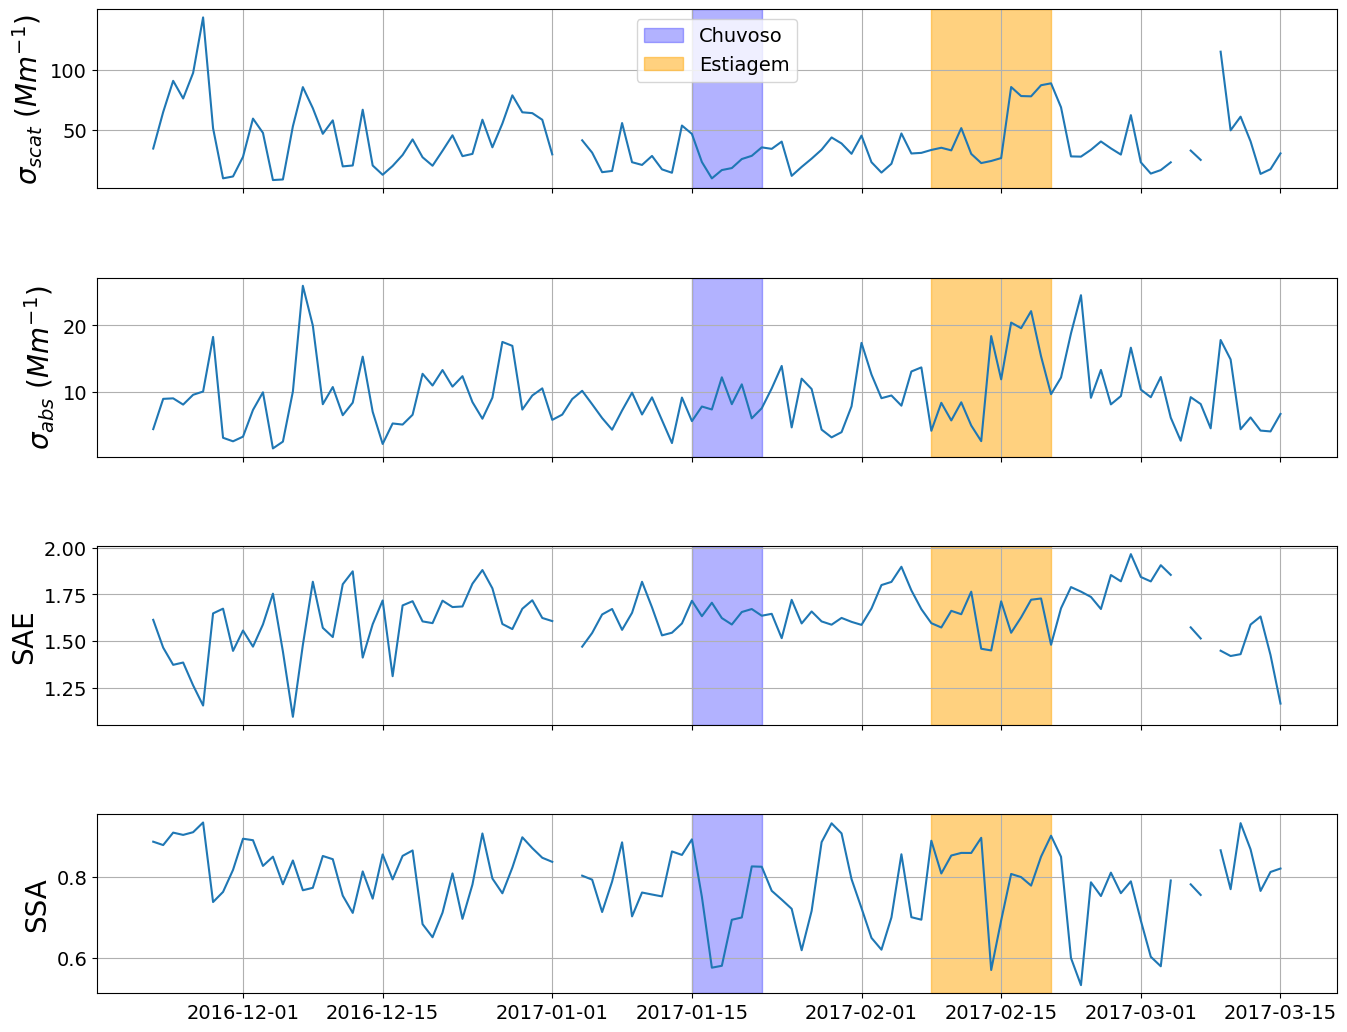

In [32]:
nefe_media_dia = nefe.resample('1440min').mean()
maap_media_dia = maap.resample('1440min').mean()


albedo_media_dia = (nefe_media_dia[' scat637 Mean (Mm-1)'])/(nefe_media_dia[' scat637 Mean (Mm-1)']+maap_media_dia[' Abs637 Mean (Mm-1)'])

fig, axes = plt.subplots(4, 1, figsize=(16, 12),sharex=True)
dados = [
    # Absorção
    (nefe_media_dia.index, nefe_media_dia[' scat637 Mean (Mm-1)'], 
     '$\sigma_{scat}~(Mm^{-1})$', 'Espalhamento'),

    (maap_media_dia.index, maap_media_dia[' Abs637 Mean (Mm-1)'], 
     '$\sigma_{abs}~(Mm^{-1})$', 'Absorção'),

    (nefe_media_dia.index, nefe_media_dia['SAE'], 
     'SAE', 'SAE'),

    (nefe_media_dia.index, albedo_media_dia, 
     'SSA', 'albedo'), 
]

# Loop para plotar os gráficos com períodos diferenciados por cor
for i, (ax, (x, y, ylabel, title)) in enumerate(zip(axes.ravel(), dados)):
    ax.plot(x, y)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid()
    
    # Adiciona regiões sombreadas para os períodos
    ax.axvspan(pd.to_datetime(start_chuvoso), pd.to_datetime(end_chuvoso), color='blue', alpha=0.3, label='Chuvoso')
    ax.axvspan(pd.to_datetime(start_estiagem), pd.to_datetime(end_estiagem), color='orange', alpha=0.5, label='Estiagem')

    # Adiciona a legenda apenas no primeiro gráfico
    if i == 0:
        ax.legend(fontsize=14)

# Ajuste dos labels no eixo x do último subplot
axes[-1].tick_params(axis='x', labelsize=14)
plt.subplots_adjust(hspace=0.5, top=0.93)

plt.show()

In [33]:
print('Scaterring:')
print('Média:',nefe_media_dia[' scat637 Mean (Mm-1)'].mean(),'+-',nefe_media_dia[' scat637 Mean (Mm-1)'].std())
print('Máximo:',nefe_media_dia[' scat637 Mean (Mm-1)'].max())
print('Mínimo',nefe_media_dia[' scat637 Mean (Mm-1)'].min())

print()
print('Absortion:')
print('Média:', maap_media_dia[' Abs637 Mean (Mm-1)'].mean(),'+-', maap_media_dia[' Abs637 Mean (Mm-1)'].std())
print('Máximo:', maap_media_dia[' Abs637 Mean (Mm-1)'].max())
print('Mínimo', maap_media_dia[' Abs637 Mean (Mm-1)'].min())
print()
print('SAE:')
print('Média:',nefe_media_dia['SAE'].mean(),'+-',nefe_media_dia['SAE'].std())
print('Máximo:',nefe_media_dia['SAE'].max())
print('Mínimo',nefe_media_dia['SAE'].min())


print()
print('SSA:')
print('Média:', albedo_media_dia.mean(),'+-', albedo_media_dia.std())
print('Máximo:',albedo_media_dia.max())
print('Mínimo', albedo_media_dia.min())

Scaterring:
Média: 39.95347413479015 +- 24.40931759139269
Máximo: 143.19571185047243
Mínimo 8.650767713374021

Absortion:
Média: 9.482570448915213 +- 4.9763625785271035
Máximo: 25.95117857142857
Mínimo 1.5268750000000002

SAE:
Média: 1.6223617657552032 +- 0.1574348306985639
Máximo: 1.9653333295059474
Mínimo 1.0931777563801244

SSA:
Média: 0.786996705680776 +- 0.09059908122647885
Máximo: 0.9342996513251273
Mínimo 0.5331855477335661


- sombreado

### Series temporais das variáveis meteorológicas

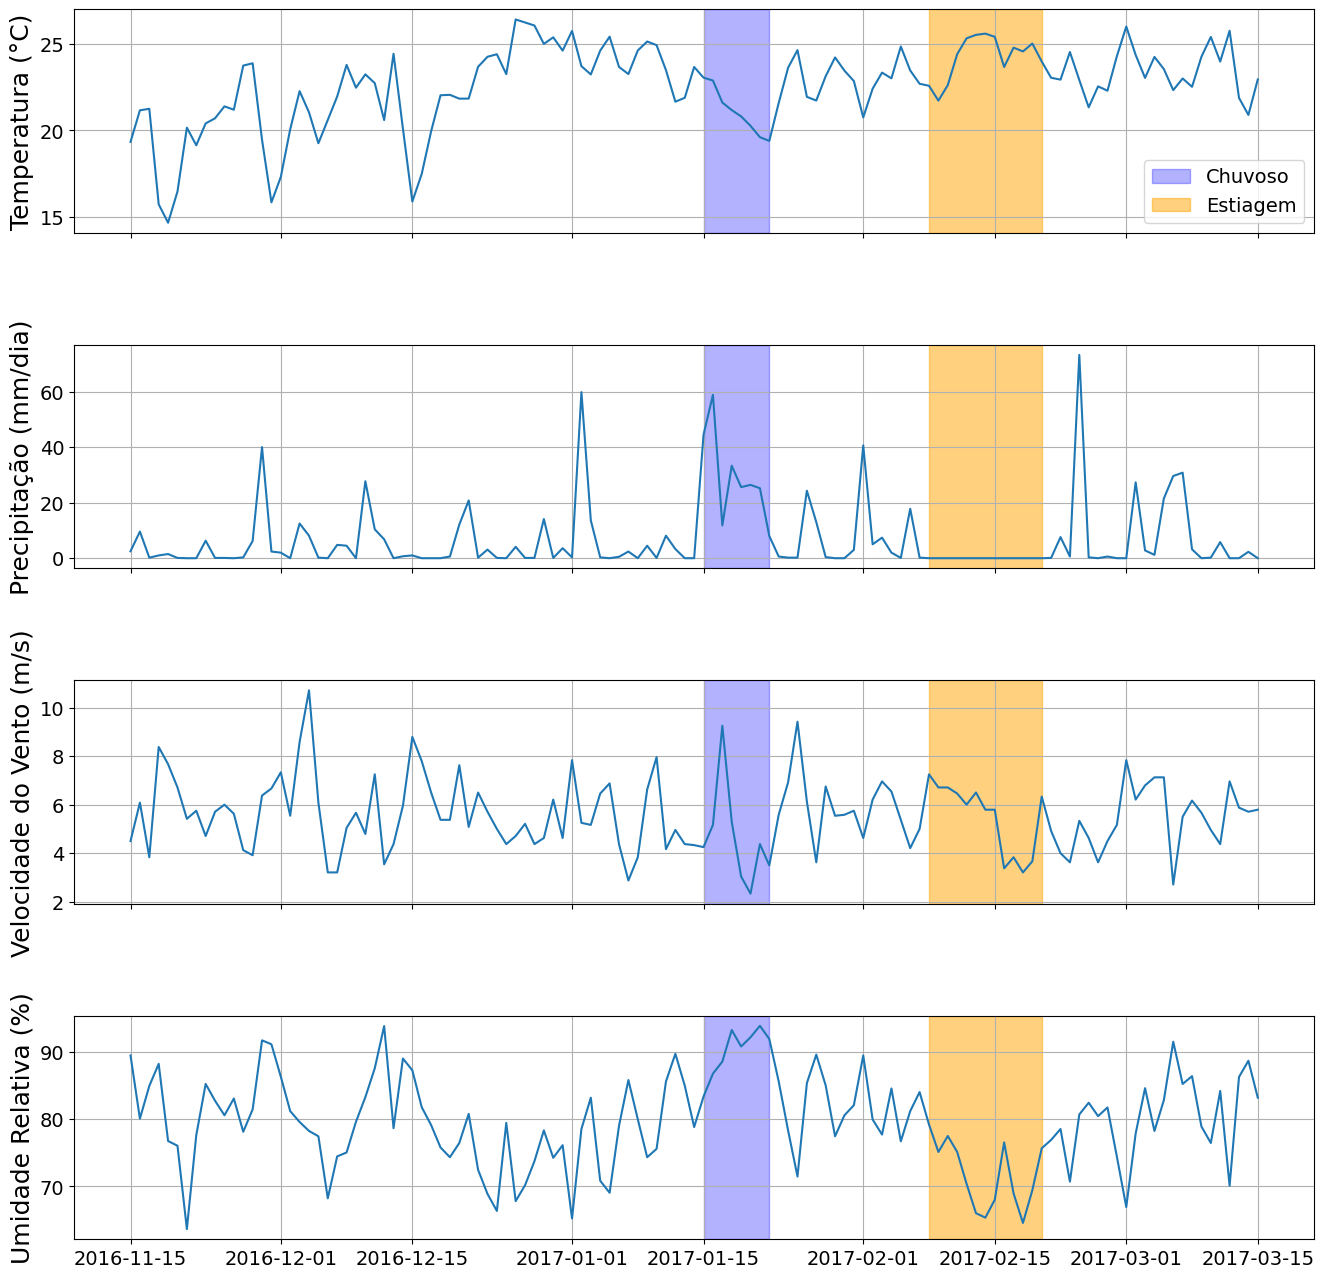

In [34]:
meteo_media_dia = meteo.resample('1440min').mean()

precipitacao_total_dia = meteo['Precipitation (mm)'].groupby(meteo['Precipitation (mm)'].index.date).sum()

fig, axes = plt.subplots(4, 1, figsize=(16,15),sharex=True)
dados = [
    # Absorção
    (meteo_media_dia.index, meteo_media_dia['Temperature (°C)'], 
     'Temperatura (°C)', 'Temperature (°C)'),

    (meteo_media_dia.index, precipitacao_total_dia, 
    'Precipitação (mm/dia)', 'Precipitation (mm/dia)'),

    (meteo_media_dia.index, meteo_media_dia['Average Wind Speed (m/s)'], 
     'Velocidade do Vento (m/s)', 'Average Wind Speed (m/s)'),

    (meteo_media_dia.index, meteo_media_dia['RH'], 
     'Umidade Relativa (%)', 'RH'), 
]

# Loop para plotar os gráficos com períodos diferenciados por cor
for i, (ax, (x, y, ylabel, title)) in enumerate(zip(axes.ravel(), dados)):
    ax.plot(x, y)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid()
    
    # Adiciona regiões sombreadas para os períodos
    ax.axvspan(pd.to_datetime(start_chuvoso), pd.to_datetime(end_chuvoso), color='blue', alpha=0.3, label='Chuvoso')
    ax.axvspan(pd.to_datetime(start_estiagem), pd.to_datetime(end_estiagem), color='orange', alpha=0.5, label='Estiagem')

    # Adiciona a legenda apenas no primeiro gráfico
    if i == 0:
        ax.legend(fontsize=14)

# Ajuste dos labels no eixo x do último subplot
axes[-1].tick_params(axis='x', labelsize=14)
plt.subplots_adjust(hspace=0.5, top=0.93)

plt.show()

### CDM temporais das variáveis meteorológicas

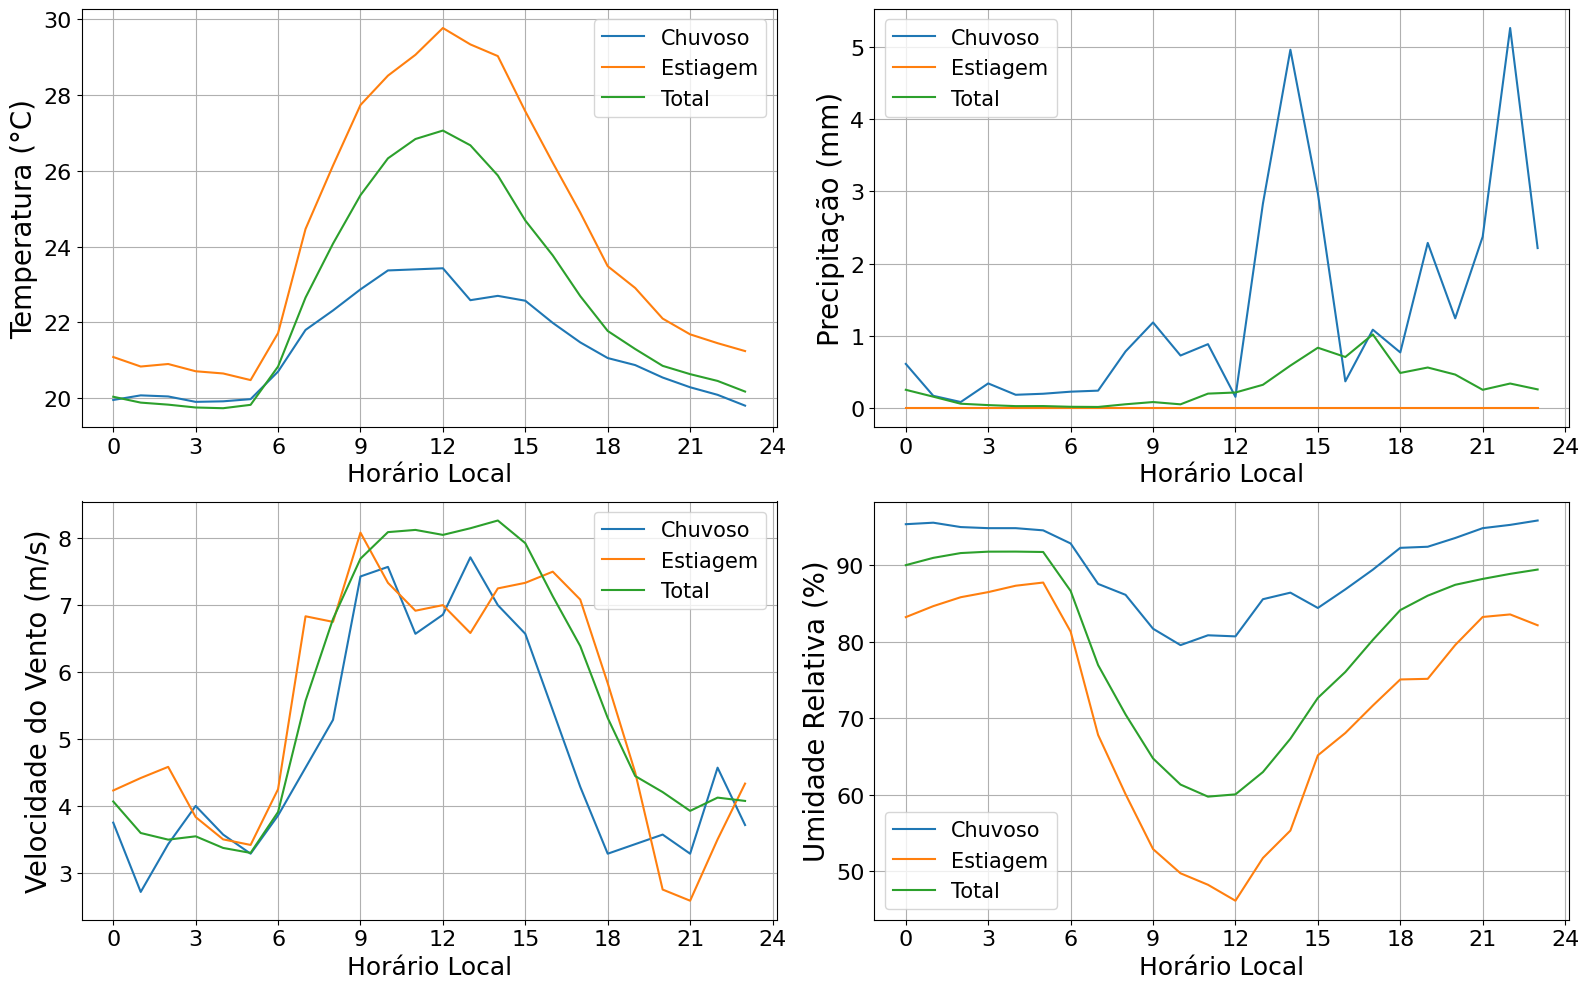

In [35]:
meteo_chuvoso = meteo.loc[start_chuvoso:end_chuvoso]
meteo_media_1h_chuvoso = meteo_chuvoso.resample('60min').mean()
meteo_media_1h_chuvoso['hour'] = meteo_media_1h_chuvoso.index.hour
# Agrupando por hora e calculando a média
meteo_cdm_chuvoso = meteo_media_1h_chuvoso.groupby('hour').mean()

meteo_estiagem = meteo.loc[start_estiagem:end_estiagem]
meteo_media_1h_estiagem = meteo_estiagem.resample('60min').mean()
meteo_media_1h_estiagem['hour'] = meteo_media_1h_estiagem.index.hour
# Agrupando por hora e calculando a média
meteo_cdm_estiagem = meteo_media_1h_estiagem.groupby('hour').mean()


fig, coluna = plt.subplots(2, 2, figsize=(16, 10))

# Labels e legendas para os gráficos
labels = ['Temperature (°C)', 'Precipitation (mm)', 'Average Wind Speed (m/s)', 'RH']
legendas = ['Temperatura (°C)', 'Precipitação (mm)', 'Velocidade do Vento (m/s)', 'Umidade Relativa (%)']

# Loop para plotar cada gráfico individualmente
for i in range(len(labels)):
    ax = coluna[i // 2, i % 2]  # Acessa a subplot correta na matriz 2x2
    ax.plot(meteo_cdm_chuvoso.index, meteo_cdm_chuvoso[labels[i]], label='Chuvoso')
    ax.plot(meteo_cdm_estiagem.index, meteo_cdm_estiagem[labels[i]], label='Estiagem')
    ax.plot(meteo_cdm.index, meteo_cdm[labels[i]], label='Total')
    
    # Definindo os rótulos e legendas com fontes maiores
    ax.set_ylabel(legendas[i], fontsize=20)
    ax.set_xlabel('Horário Local', fontsize=18)
    ax.set_xticks(np.arange(0, 24.001, 3))
    ax.tick_params(axis='both', labelsize=16)  # Ajusta o tamanho dos ticks (eixo x e y)
    ax.grid()
    ax.legend(fontsize=15)  # Tamanho da fonte da legenda

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

### CDM propriedades ópticas

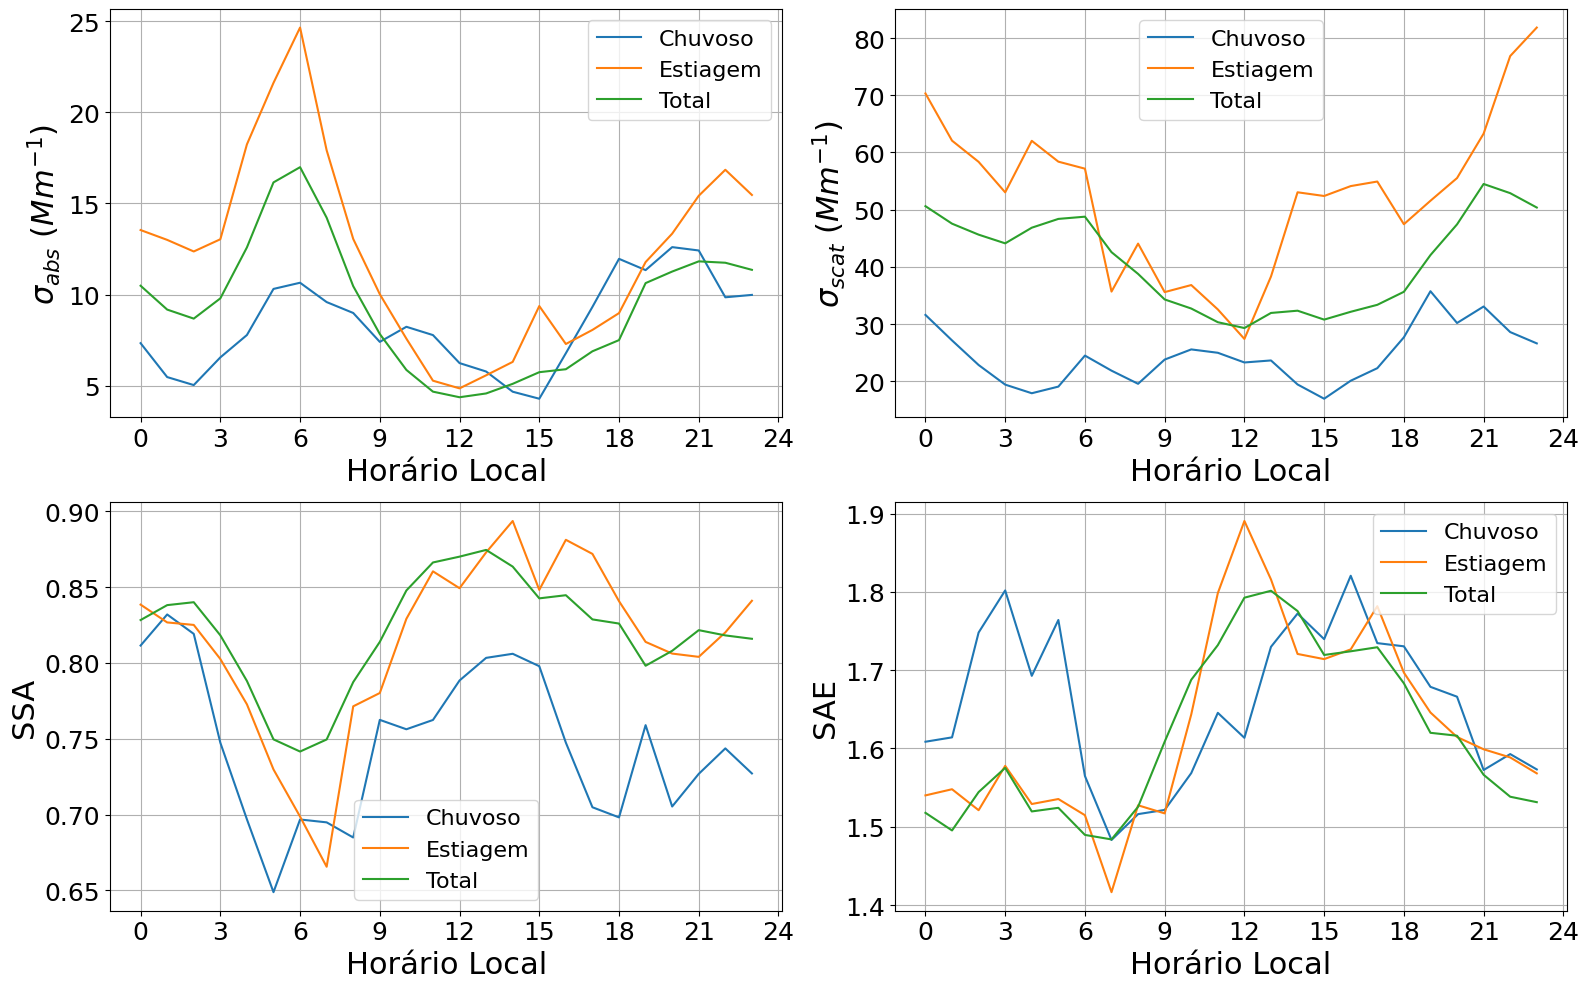

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Criar subplots com uma matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Dados chuvoso e estiagem organizados para o loop
dados = [
    # Absorção
    (maap_cdm_chuvoso.index, maap_cdm_chuvoso[' Abs637 Mean (Mm-1)'], maap_cdm_estiagem[' Abs637 Mean (Mm-1)'], maap_cdm[' Abs637 Mean (Mm-1)'],
     '$\sigma_{abs}~(Mm^{-1})$', 'CDM - Absorção - Diadema'),
    
    # Espalhamento
    (nefe_albedo_cdm_chuvoso.index, scat637_cdm_chuvoso, scat637_cdm_estiagem, scat637_cdm,
     '$\sigma_{scat}~(Mm^{-1})$', 'CDM - Espalhamento - Diadema'),
    
    # Albedo (SSA)
    (maap_cdm_chuvoso.index, albedo_cdm_chuvoso, albedo_cdm_estiagem, albedo_cdm,
     'SSA', 'CDM - SSA - Diadema'),

    # SAE
    (nefe_albedo_cdm_chuvoso.index, nefe_albedo_cdm_chuvoso['SAE'], nefe_albedo_cdm_estiagem['SAE'], 
     nefe_albedo_cdm['SAE'],
     'SAE', 'CDM - SAE - Diadema'),
]

# Loop para plotar os gráficos com períodos diferenciados por cor
for ax, (x_chuvoso, y_chuvoso, y_estiagem, y_total, ylabel, title) in zip(axes.flat, dados):
    ax.plot(x_chuvoso, y_chuvoso, label='Chuvoso')
    ax.plot(x_chuvoso, y_estiagem, label='Estiagem')
    ax.plot(x_chuvoso, y_total, label='Total')

    # Configurando fontes maiores para rótulos, títulos e legenda
    ax.set_ylabel(ylabel, fontsize=22)
    ax.set_xlabel('Horário Local', fontsize=22)
    ax.set_xticks(np.arange(0, 24.001, 3))
    ax.tick_params(axis='both', labelsize=18)  # Aumenta o tamanho dos ticks no eixo x e y
    ax.legend(fontsize=16)  # Aumenta o tamanho da fonte da legenda
    ax.grid()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


### Wilcoxon rank-sum

In [37]:
from scipy.stats import mannwhitneyu

dados = [
    (nefe_estiagem,nefe_chuvoso, ' scat637 Mean (Mm-1)', '$\sigma_{scat}~(Mm^{-1})$', 'Espalhamento'),
    (maap_estiagem,maap_chuvoso, ' Abs637 Mean (Mm-1)', '$\sigma_{abs}~(Mm^{-1})$', 'Absorção'),
    (nefe_estiagem,nefe_chuvoso, 'SAE', 'SAE', 'SAE'),

]
for i, (df_estiagem,df_chuvoso, col, ylabel, title) in enumerate(dados):
    # Realizando o teste de Wilcoxon rank-sum
    stat, p_value = mannwhitneyu(df_estiagem['%s'%(col)], df_chuvoso['%s'%(col)],nan_policy='omit')
    print(title)
    # Exibindo os resultados
    print(f"Estatística do teste: {stat}")
    print(f"Valor-p: {p_value}")

    # Interpretando o resultado
    alpha = 0.05  # Nível de significância
    if p_value < alpha:
        print("Rejeitamos a hipótese nula: há uma diferença significativa entre as séries.")
    else:
        print("Não rejeitamos a hipótese nula: não há uma diferença significativa entre as séries.")

    print('\n \n')
stat, p_value = mannwhitneyu(albedo_chuvoso_dia, albedo_estiagem_dia,nan_policy='omit')
print(title)
# Exibindo os resultados
print(f"Estatística do teste: {stat}")
print(f"Valor-p: {p_value}")

# Interpretando o resultado
alpha = 0.05  # Nível de significância
if p_value < alpha:
    print("Rejeitamos a hipótese nula: há uma diferença significativa entre as séries.")
else:
    print("Não rejeitamos a hipótese nula: não há uma diferença significativa entre as séries.")


Espalhamento
Estatística do teste: 3891434.0
Valor-p: 2.1702851355353115e-164
Rejeitamos a hipótese nula: há uma diferença significativa entre as séries.

 

Absorção
Estatística do teste: 3560335.0
Valor-p: 3.41182018505901e-20
Rejeitamos a hipótese nula: há uma diferença significativa entre as séries.

 

SAE
Estatística do teste: 2479372.0
Valor-p: 0.00014770002632260313
Rejeitamos a hipótese nula: há uma diferença significativa entre as séries.

 

SAE
Estatística do teste: 9795.0
Valor-p: 4.3568560067609804e-17
Rejeitamos a hipótese nula: há uma diferença significativa entre as séries.


### iNTERVALOS

In [43]:
dados = [
    (nefe, ' scat637 Mean (Mm-1)', '$\sigma_{scat}~(Mm^{-1})$', 'Espalhamento'),
    (maap, ' Abs637 Mean (Mm-1)', '$\sigma_{abs}~(Mm^{-1})$', 'Absorção'),

]
for i, (data, col, ylabel, title) in enumerate(dados):
    print(title)
    Q1 = data['%s'%(col)].quantile(0.25)
    Q3 = data['%s'%(col)].quantile(0.75)

    # Calculando o IQR
    IQR = Q3 - Q1

    print(f"Q1: {Q1}")
    print(f"Q3: {Q3}")
    print(f"IQR: {IQR}")
    print()
    Q1 = 0
    Q3 = 0

print('Albedo')    
Q1 = albedo.quantile(0.25)
Q3 = albedo.quantile(0.75)

# Calculando o IQR
IQR = Q3 - Q1

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")

Espalhamento
Q1: 15.625415047159908
Q3: 52.46875416614837
IQR: 36.84333911898847

Absorção
Q1: 3.42
Q3: 12.95
IQR: 9.53

Albedo
Q1: 0.7162625576811441
Q3: 0.8759195651249503
IQR: 0.15965700744380618


### SMPS

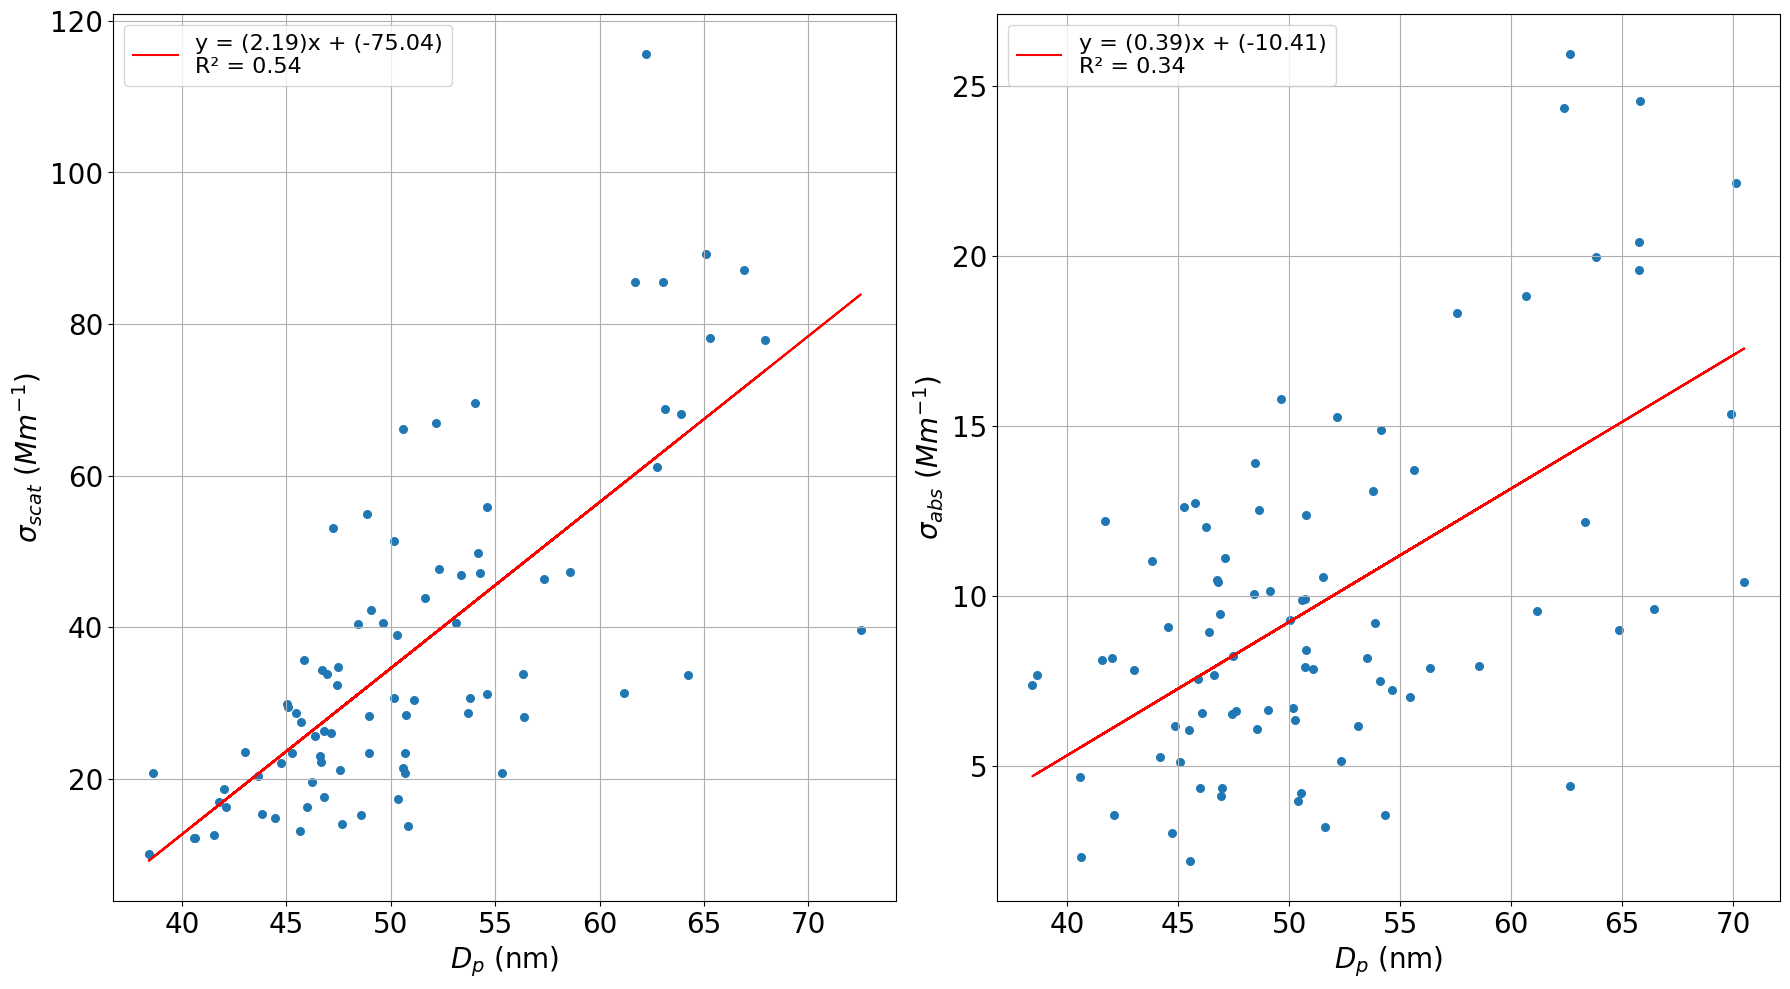

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Dados de exemplo
dados = [
    (nefe, ' scat637 Mean (Mm-1)', '$\sigma_{scat}~(Mm^{-1})$', 'Espalhamento'),
    (maap, ' Abs637 Mean (Mm-1)', '$\sigma_{abs}~(Mm^{-1})$', 'Absorção'),
]

# Criar uma figura com subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 10))  # 1 linha, 2 colunas

# Loop sobre os dados
for i, (data, col, ylabel, title) in enumerate(dados):
    # Encontrar índices comuns
    indices_comuns = data.index.intersection(smps.index)

    # Filtrar os dados para manter apenas os índices comuns
    data_filtrado = data.loc[indices_comuns]
    smps_filtrado = smps.loc[indices_comuns]

    # Calcular médias diárias
    data_filtrado = data_filtrado.resample('1440min').mean()
    smps_filtrado = smps_filtrado.resample('1440min').mean()

    # Extrair variáveis x e y
    y = data_filtrado['%s' % (col)]
    x = smps_filtrado[' Mean geometric diameter Dpg (nm)']

    # Remover valores NaN ou inf de x e y
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
    x_clean = x[mask]
    y_clean = y[mask]

    # Verificar se há dados suficientes para a regressão
    if len(x_clean) < 2 or len(y_clean) < 2:
        print(f"Não há dados suficientes para calcular a regressão para {title}.")
        continue

    # Calcular a regressão linear
    slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
    line = slope * x_clean + intercept  # Equação da reta

    # Plotar no subplot correspondente
    ax = axes[i]
    ax.scatter(x_clean, y_clean, s=30)
    ax.plot(x_clean, line, color='red', label=f'y = ({slope:.2f})x + ({intercept:.2f})\nR² = {r_value**2:.2f}')

    # Configurações do gráfico
    ax.set_xlabel('$D_p$ (nm)', fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
 
    ax.tick_params(axis='both', labelsize=20)
    ax.legend(fontsize=16)
    ax.grid()

# Ajustar layout e mostrar a figura
plt.tight_layout()
plt.show()